In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

%matplotlib inline

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 78)

In [2]:
test_file = '../data/test.csv'
train_file = '../data/train.csv'
spray_file = '../data/spray.csv'
weather_file = '../data/weather.csv'

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
spray_df = pd.read_csv(spray_file)
weather_df = pd.read_csv(weather_file)

In [3]:
weather_df

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2,2014-10-29,49,40,45,M,34,42,20,0,-,-,,M,M,M,0.00,29.42,30.07,8.5,29,9.0
2940,1,2014-10-30,51,32,42,-4,34,40,23,0,0622,1649,,0,M,0.0,0.00,29.34,30.09,5.1,24,5.5
2941,2,2014-10-30,53,37,45,M,35,42,20,0,-,-,RA,M,M,M,T,29.41,30.10,5.9,23,6.5
2942,1,2014-10-31,47,33,40,-6,25,33,25,0,0623,1647,RA SN,0,M,0.1,0.03,29.49,30.20,22.6,34,22.9


In [4]:
# Correct for the missing data in Tavg col
weather_df['Tavg'] = (weather_df['Tmax'] + weather_df['Tmin'])/2

In [5]:
for col in weather_df.columns:
    weather_df[col] = weather_df[col].map(lambda x: np.nan if x=='M' else x)

In [6]:
weather_df.isnull().sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg              0
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

In [7]:
weather_df[weather_df['Station']==1].isnull().sum()

Station           0
Date              0
Tmax              0
Tmin              0
Tavg              0
Depart            0
DewPoint          0
WetBulb           3
Heat              0
Cool              0
Sunrise           0
Sunset            0
CodeSum           0
Depth             0
Water1         1472
SnowFall          0
PrecipTotal       0
StnPressure       2
SeaLevel          5
ResultSpeed       0
ResultDir         0
AvgSpeed          0
dtype: int64

In [8]:
weather_df[weather_df['Station']==2].isnull().sum()   # drop Station 2 with a lot of NaNs

Station           0
Date              0
Tmax              0
Tmin              0
Tavg              0
Depart         1472
DewPoint          0
WetBulb           1
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         1472
SnowFall       1472
PrecipTotal       2
StnPressure       2
SeaLevel          4
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

In [9]:
weather_df.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [10]:
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df.set_index('Date', inplace=True)
weather_df.index

DatetimeIndex(['2007-05-01', '2007-05-01', '2007-05-02', '2007-05-02',
               '2007-05-03', '2007-05-03', '2007-05-04', '2007-05-04',
               '2007-05-05', '2007-05-05',
               ...
               '2014-10-27', '2014-10-27', '2014-10-28', '2014-10-28',
               '2014-10-29', '2014-10-29', '2014-10-30', '2014-10-30',
               '2014-10-31', '2014-10-31'],
              dtype='datetime64[ns]', name='Date', length=2944, freq=None)

In [11]:
# Create new cols for Month and Year index
weather_df['month'] = weather_df.index.month
weather_df['year'] = weather_df.index.year
weather_df['week'] = weather_df.index.week


C:\Users\samue\AppData\Local\Temp\ipykernel_16536\2314987516.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weather_df['week'] = weather_df.index.week


In [12]:
# Define a function to create a col for YearWeek

def year_week(row):
    week = row['week']
    year = row['year']
    row['YearWeek'] = f'{year}{week}'
    row['YearWeek'] = int(row['YearWeek'])
    return row

In [13]:
# Create new col for YearWeek 
weather_df = weather_df.apply(year_week, axis=1)

In [14]:
weather_df[weather_df['Station']==1].head(10)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,month,year,week,YearWeek
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,66.5,14,51,56,0,2,0448,1849,,0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2,5,2007,18,200718
2007-05-02,1,59,42,50.5,-3,42,47,14,0,0447,1850,BR,0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4,5,2007,18,200718
2007-05-03,1,66,46,56.0,2,40,48,9,0,0446,1851,,0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9,5,2007,18,200718
2007-05-04,1,66,49,57.5,4,41,50,7,0,0444,1852,RA,0,NaN,0.0,T,29.31,30.05,10.4,8,10.8,5,2007,18,200718
2007-05-05,1,66,53,59.5,5,38,49,5,0,0443,1853,,0,NaN,0.0,T,29.40,30.10,11.7,7,12.0,5,2007,18,200718
2007-05-06,1,68,49,58.5,4,30,46,6,0,0442,1855,,0,NaN,0.0,0.00,29.57,30.29,14.4,11,15.0,5,2007,18,200718
2007-05-07,1,83,47,65.0,10,41,54,0,0,0441,1856,RA,0,NaN,0.0,T,29.38,30.12,8.6,18,10.5,5,2007,19,200719
2007-05-08,1,82,54,68.0,12,58,62,0,3,0439,1857,BR,0,NaN,0.0,0.00,29.29,30.03,2.7,11,5.8,5,2007,19,200719
2007-05-09,1,77,61,69.0,13,59,63,0,4,0438,1858,BR HZ,0,NaN,0.0,0.13,29.21,29.94,3.9,9,6.2,5,2007,19,200719


In [15]:
station_1_weather = weather_df[weather_df['Station']==1].copy()

station_1_weather.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,month,year,week,YearWeek
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,66.5,14,51,56,0,2,0448,1849,,0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2,5,2007,18,200718
2007-05-02,1,59,42,50.5,-3,42,47,14,0,0447,1850,BR,0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4,5,2007,18,200718
2007-05-03,1,66,46,56.0,2,40,48,9,0,0446,1851,,0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9,5,2007,18,200718
2007-05-04,1,66,49,57.5,4,41,50,7,0,0444,1852,RA,0,NaN,0.0,T,29.31,30.05,10.4,8,10.8,5,2007,18,200718
2007-05-05,1,66,53,59.5,5,38,49,5,0,0443,1853,,0,NaN,0.0,T,29.40,30.10,11.7,7,12.0,5,2007,18,200718


In [16]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.set_index('Date', inplace=True)
train_df.index

DatetimeIndex(['2007-05-29', '2007-05-29', '2007-05-29', '2007-05-29',
               '2007-05-29', '2007-05-29', '2007-05-29', '2007-05-29',
               '2007-05-29', '2007-05-29',
               ...
               '2013-09-26', '2013-09-26', '2013-09-26', '2013-09-26',
               '2013-09-26', '2013-09-26', '2013-09-26', '2013-09-26',
               '2013-09-26', '2013-09-26'],
              dtype='datetime64[ns]', name='Date', length=10506, freq=None)

In [17]:
# Create new cols for Month and Year index
train_df['month'] = train_df.index.month
train_df['year'] = train_df.index.year
train_df['week'] = train_df.index.week

# Create new col for YearWeek 
train_df = train_df.apply(year_week, axis=1)

train_df.head(10)

C:\Users\samue\AppData\Local\Temp\ipykernel_16536\2236318622.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train_df['week'] = train_df.index.week


,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,month,year,week,YearWeek
Date,,,,,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,2007,22,200722
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0,5,2007,22,200722
2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0,5,2007,22,200722
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0,5,2007,22,200722
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0,5,2007,22,200722
2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0,5,2007,22,200722
2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0,5,2007,22,200722
2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0,5,2007,22,200722
2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0,5,2007,22,200722


In [18]:
train_weather = pd.merge(train_df[['WnvPresent','NumMosquitos','Longitude','Latitude']], station_1_weather[['Tmax', 'Tmin', 'Tavg', 'DewPoint', 
         'Heat', 'Cool', 'Sunrise', 'Sunset','ResultSpeed', 'ResultDir', 'AvgSpeed']], on='Date')

In [19]:
train_weather.shape

(10506, 15)

In [20]:
train_weather.isna().sum()

WnvPresent      0
NumMosquitos    0
Longitude       0
Latitude        0
Tmax            0
Tmin            0
Tavg            0
DewPoint        0
Heat            0
Cool            0
Sunrise         0
Sunset          0
ResultSpeed     0
ResultDir       0
AvgSpeed        0
dtype: int64

In [21]:
train_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   WnvPresent    10506 non-null  int64  
 1   NumMosquitos  10506 non-null  int64  
 2   Longitude     10506 non-null  float64
 3   Latitude      10506 non-null  float64
 4   Tmax          10506 non-null  int64  
 5   Tmin          10506 non-null  int64  
 6   Tavg          10506 non-null  float64
 7   DewPoint      10506 non-null  int64  
 8   Heat          10506 non-null  object 
 9   Cool          10506 non-null  object 
 10  Sunrise       10506 non-null  object 
 11  Sunset        10506 non-null  object 
 12  ResultSpeed   10506 non-null  float64
 13  ResultDir     10506 non-null  int64  
 14  AvgSpeed      10506 non-null  object 
dtypes: float64(4), int64(6), object(5)
memory usage: 1.3+ MB


<AxesSubplot:xlabel='Date'>

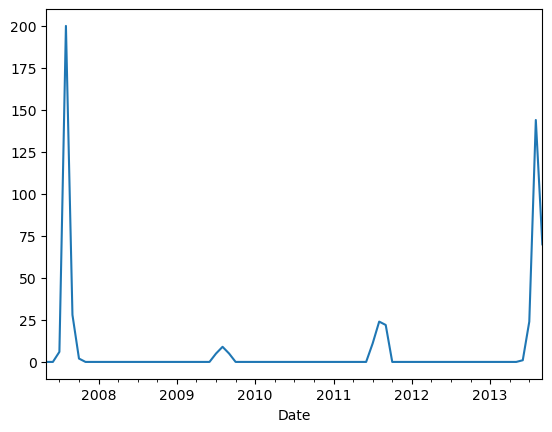

In [22]:
train_weather.resample('M')['WnvPresent'].sum().plot()

<AxesSubplot:xlabel='Date'>

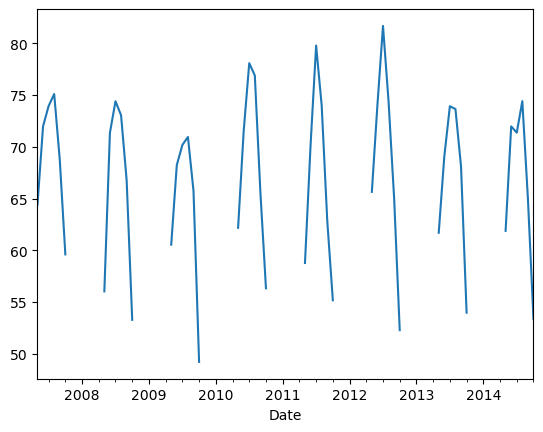

In [23]:
weather_df.resample('M')['Tavg'].mean().plot()

## Monthly Trend Analysis

In [24]:
monthly_WnvPresent = train_weather.resample('M')['WnvPresent'].sum().to_frame()     # .loc[:,'2009']
monthly_WnvPresent['month'] = monthly_WnvPresent.index.month
monthly_WnvPresent['year'] = monthly_WnvPresent.index.year


# >90% of WnvPresent identified in the months of 7,8,9
# Total cases of WnvPresent always peak in August (should the 'month' feature be timestep or Ordinal encoded then?)

In [25]:
# Group all WnvPresent counts sequentially by month and by year for barplot visualization

monthly_WnvPresent_dict = {2007:[], 2009:[], 2011:[], 2013:[]}

for year in [2007,2009,2011,2013]:
    for month in np.arange(1,13):
        condition = monthly_WnvPresent[(monthly_WnvPresent['month']==month) & (monthly_WnvPresent['year']==year)]
        if condition.empty:
            monthly_WnvPresent_dict[year].append(0)
        else:
            monthly_WnvPresent_dict[year].append(condition['WnvPresent'].values[0])
            
monthly_WnvPresent_dict

{2007: [0, 0, 0, 0, 0, 0, 6, 200, 28, 2, 0, 0],
 2009: [0, 0, 0, 0, 0, 0, 5, 9, 5, 0, 0, 0],
 2011: [0, 0, 0, 0, 0, 0, 11, 24, 22, 0, 0, 0],
 2013: [0, 0, 0, 0, 0, 1, 24, 144, 70, 0, 0, 0]}

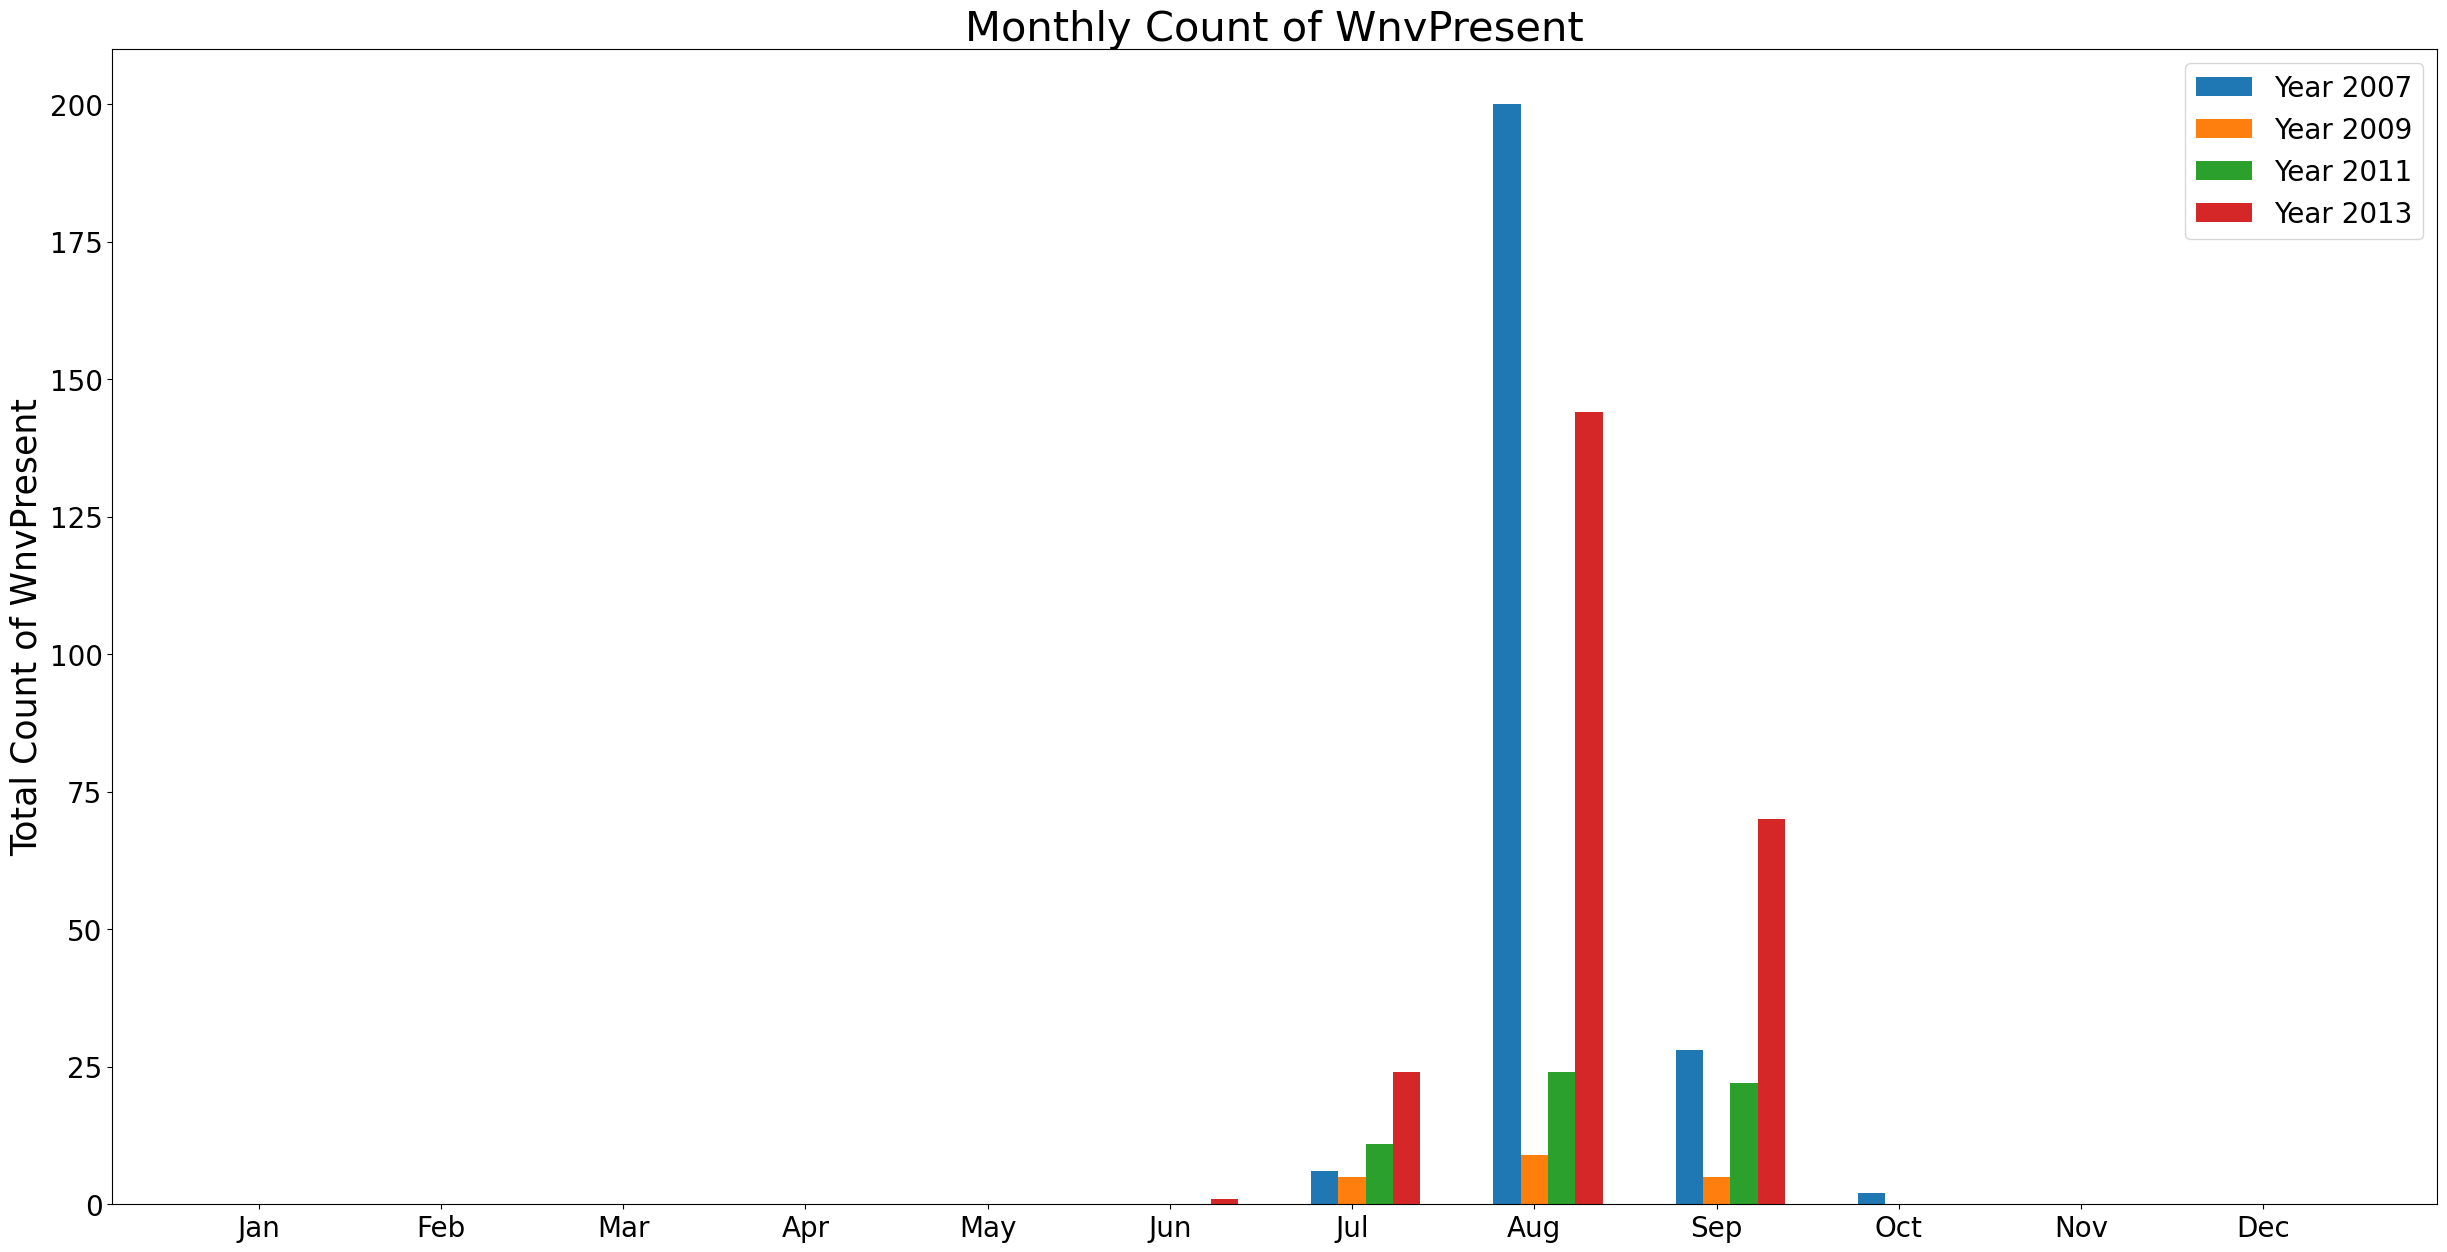

In [26]:
# Create dataset
x_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Set the width of the bars
barWidth = 0.15

# Set the positions of the bars on the x-axis
bar_widths = {2007:np.arange(len(monthly_WnvPresent_dict[2007]))}

for year in [2009,2011,2013]:
    bar_widths[year] = [x + barWidth for x in bar_widths[year-2]]


    

# Create the grouped bar plot
plt.figure(figsize=(30,15))
for year in [2007,2009,2011,2013]:
    plt.bar(bar_widths[year], monthly_WnvPresent_dict[year], width=barWidth, label=f'Year {year}')


# Add x-axis ticks and labels
plt.xticks([r + barWidth for r in range(len(monthly_WnvPresent_dict[2007]))], x_labels, fontsize=20)
plt.yticks(fontsize=20)

# Add y-label
plt.ylabel('Total Count of WnvPresent', fontsize=25)

# Add a legend and title
plt.legend(fontsize=20)
plt.title('Monthly Count of WnvPresent', fontsize=30)

# Show the plot
plt.show()

In [27]:
monthly_Tavg = train_weather.resample('M')['Tavg'].mean().to_frame()     # .loc[:,'2009']
monthly_Tavg['month'] = monthly_Tavg.index.month
monthly_Tavg['year'] = monthly_Tavg.index.year

monthly_Tavg

,Tavg,month,year
Date,,,
2007-05-31,74.000000,5,2007
2007-06-30,67.602273,6,2007
2007-07-31,73.376522,7,2007
2007-08-31,78.212195,8,2007
2007-09-30,73.220284,9,2007
...,...,...,...
2013-05-31,NaN,5,2013
2013-06-30,70.415138,6,2013
2013-07-31,75.262579,7,2013


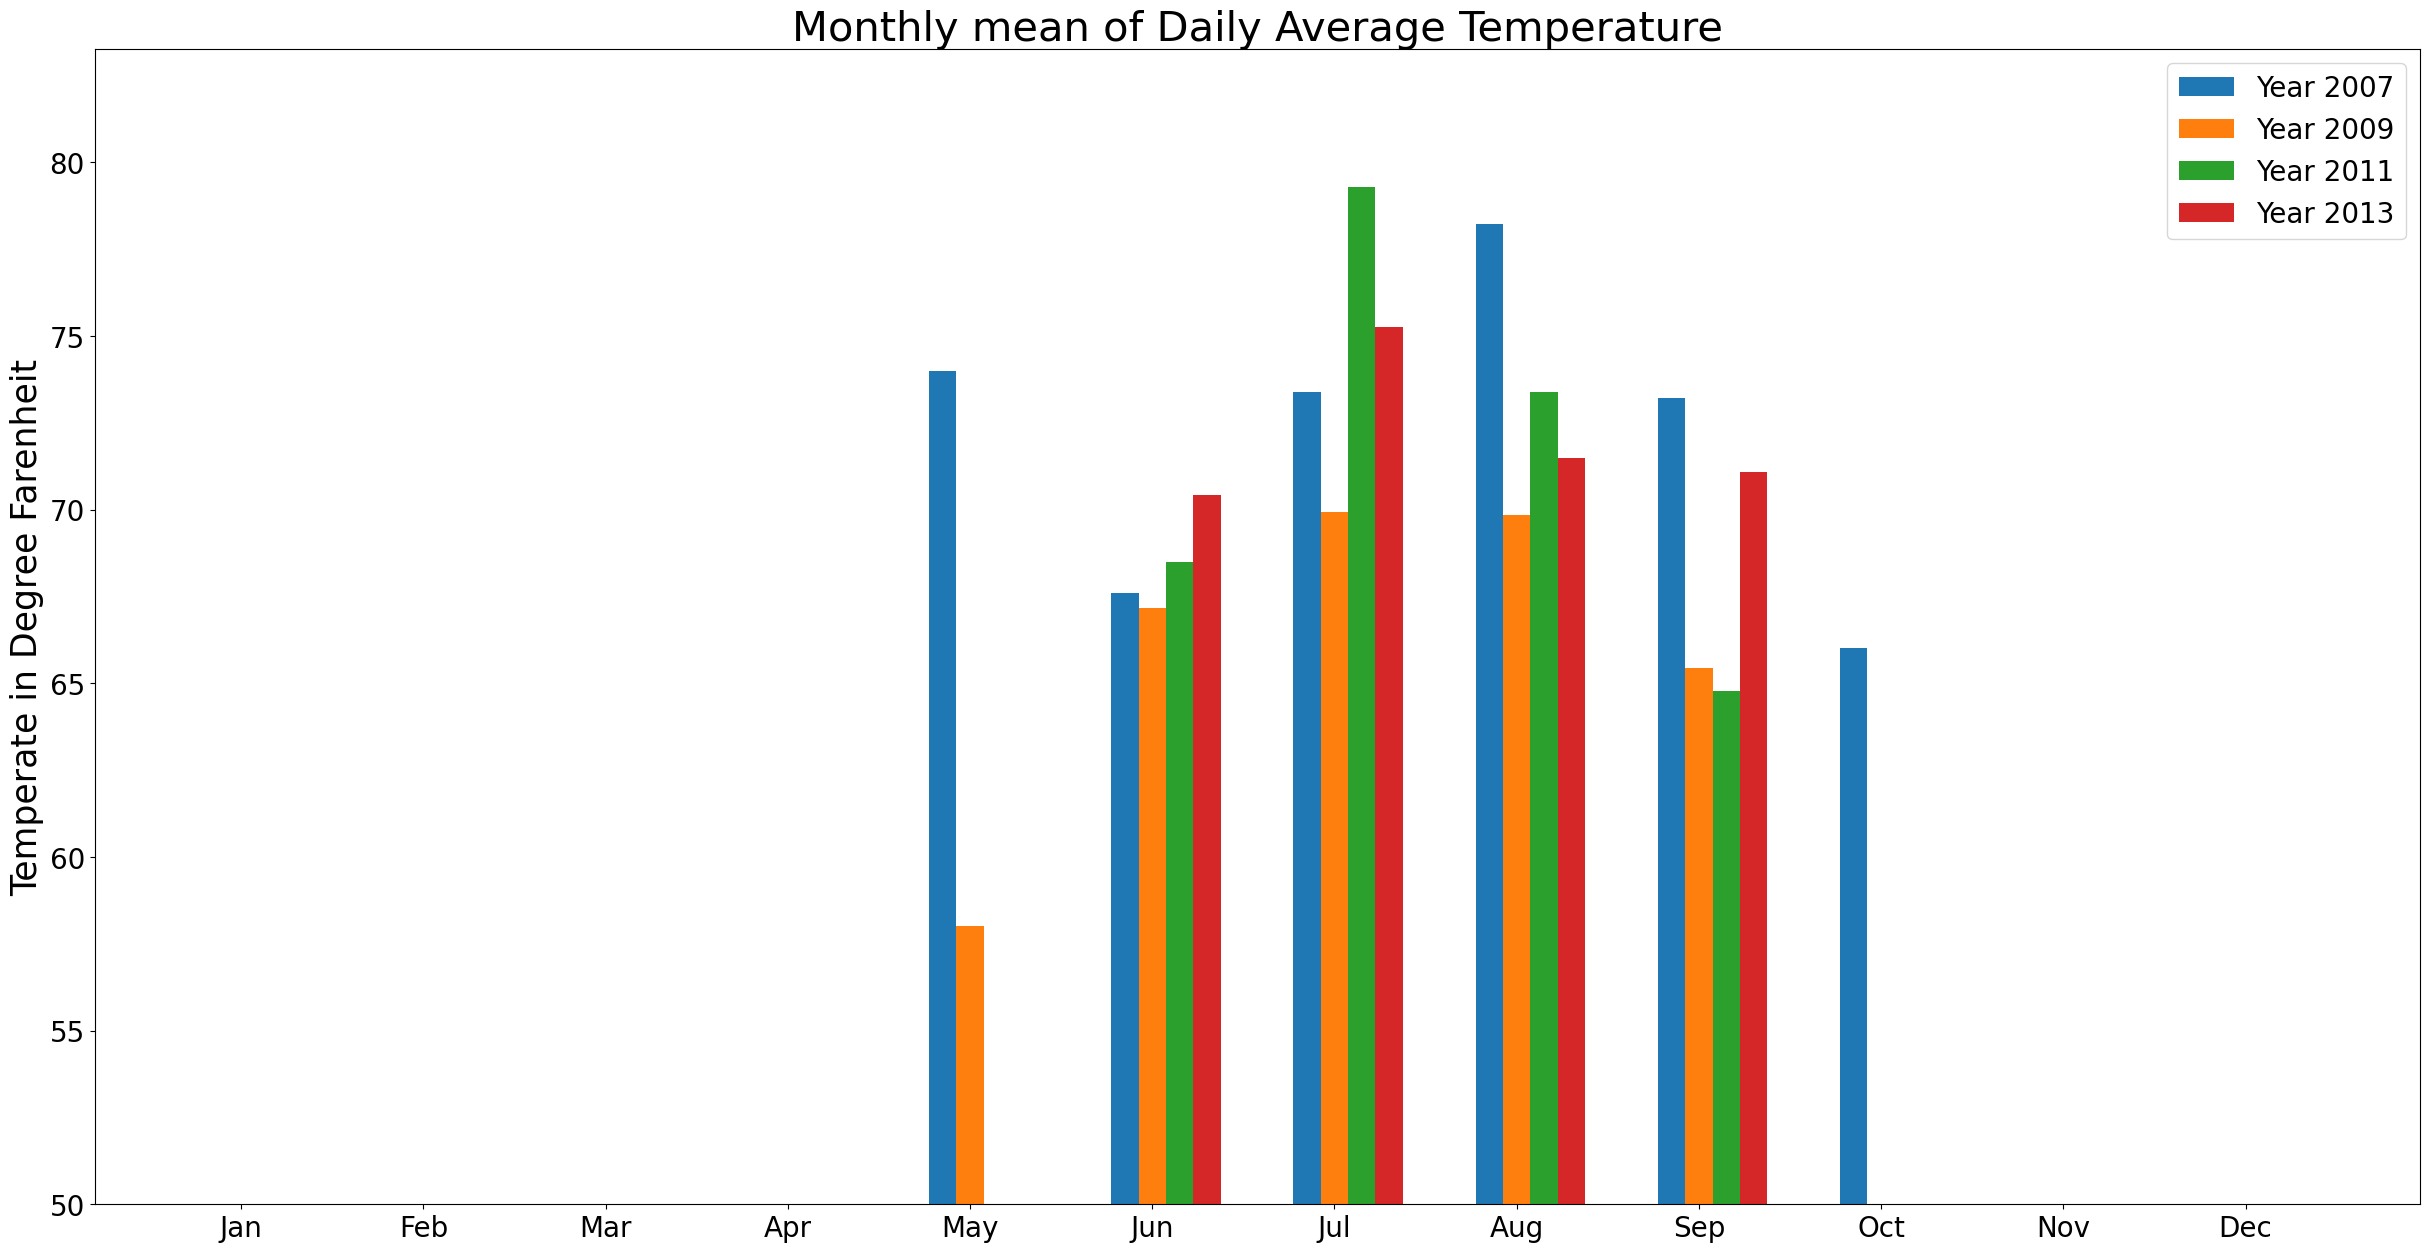

In [28]:
# Group Tavg sequentially by month and by year for barplot visualization

monthly_Tavg_dict = {2007:[], 2009:[], 2011:[], 2013:[]}

for year in [2007,2009,2011,2013]:
    for month in np.arange(1,13):
        condition = monthly_Tavg[(monthly_Tavg['month']==month) & (monthly_Tavg['year']==year)]
        if condition.empty:
            monthly_Tavg_dict[year].append(0)
        else:
            monthly_Tavg_dict[year].append(condition['Tavg'].values[0])

            

# Create dataset
x_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Set the width of the bars
barWidth = 0.15

# Set the positions of the bars on the x-axis
bar_widths = {2007:np.arange(len(monthly_Tavg_dict[2007]))}

for year in [2009,2011,2013]:
    bar_widths[year] = [x + barWidth for x in bar_widths[year-2]]


    

# Create the grouped bar plot
plt.figure(figsize=(30,15))
for year in [2007,2009,2011,2013]:
    plt.bar(bar_widths[year], monthly_Tavg_dict[year], width=barWidth, label=f'Year {year}')


# Add x-axis ticks and labels
plt.xticks([r + barWidth for r in range(len(monthly_Tavg_dict[2007]))], x_labels, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(bottom=50)

# Add y-label
plt.ylabel('Temperate in Degree Farenheit', fontsize=25)

# Add a legend and title
plt.legend(fontsize=20, loc='upper right')
plt.title('Monthly mean of Daily Average Temperature', fontsize=30)

# Show the plot
plt.show()

We know that WnvPresent tends to peak in Aug.  

From the temperature data, the daily average temp tends to peak between July and Aug inconsistently. In 2007 and 2009, temp peaked in Aug while in 2011 and 2013, temp peaked in July.  

**Optimal temp for mosquitos to thrive appears to be between 70-80 degreeF. If the previous month's temp is coming within this optimal range, we can expect the current month cases of WnvPresent to start peaking.**

So it may be value-adding if we add both the T and and lag-1 and lag-2 features of Tavg time series?

In [29]:
monthly_Tmin = train_weather.resample('M')['Tmin'].mean().to_frame()     # .loc[:,'2009']
monthly_Tmin['month'] = monthly_Tmin.index.month
monthly_Tmin['year'] = monthly_Tmin.index.year

monthly_Tmin

,Tmin,month,year
Date,,,
2007-05-31,60.000000,5,2007
2007-06-30,58.500000,6,2007
2007-07-31,65.085217,7,2007
2007-08-31,69.289268,8,2007
2007-09-30,62.430233,9,2007
...,...,...,...
2013-05-31,NaN,5,2013
2013-06-30,61.137615,6,2013
2013-07-31,63.724843,7,2013


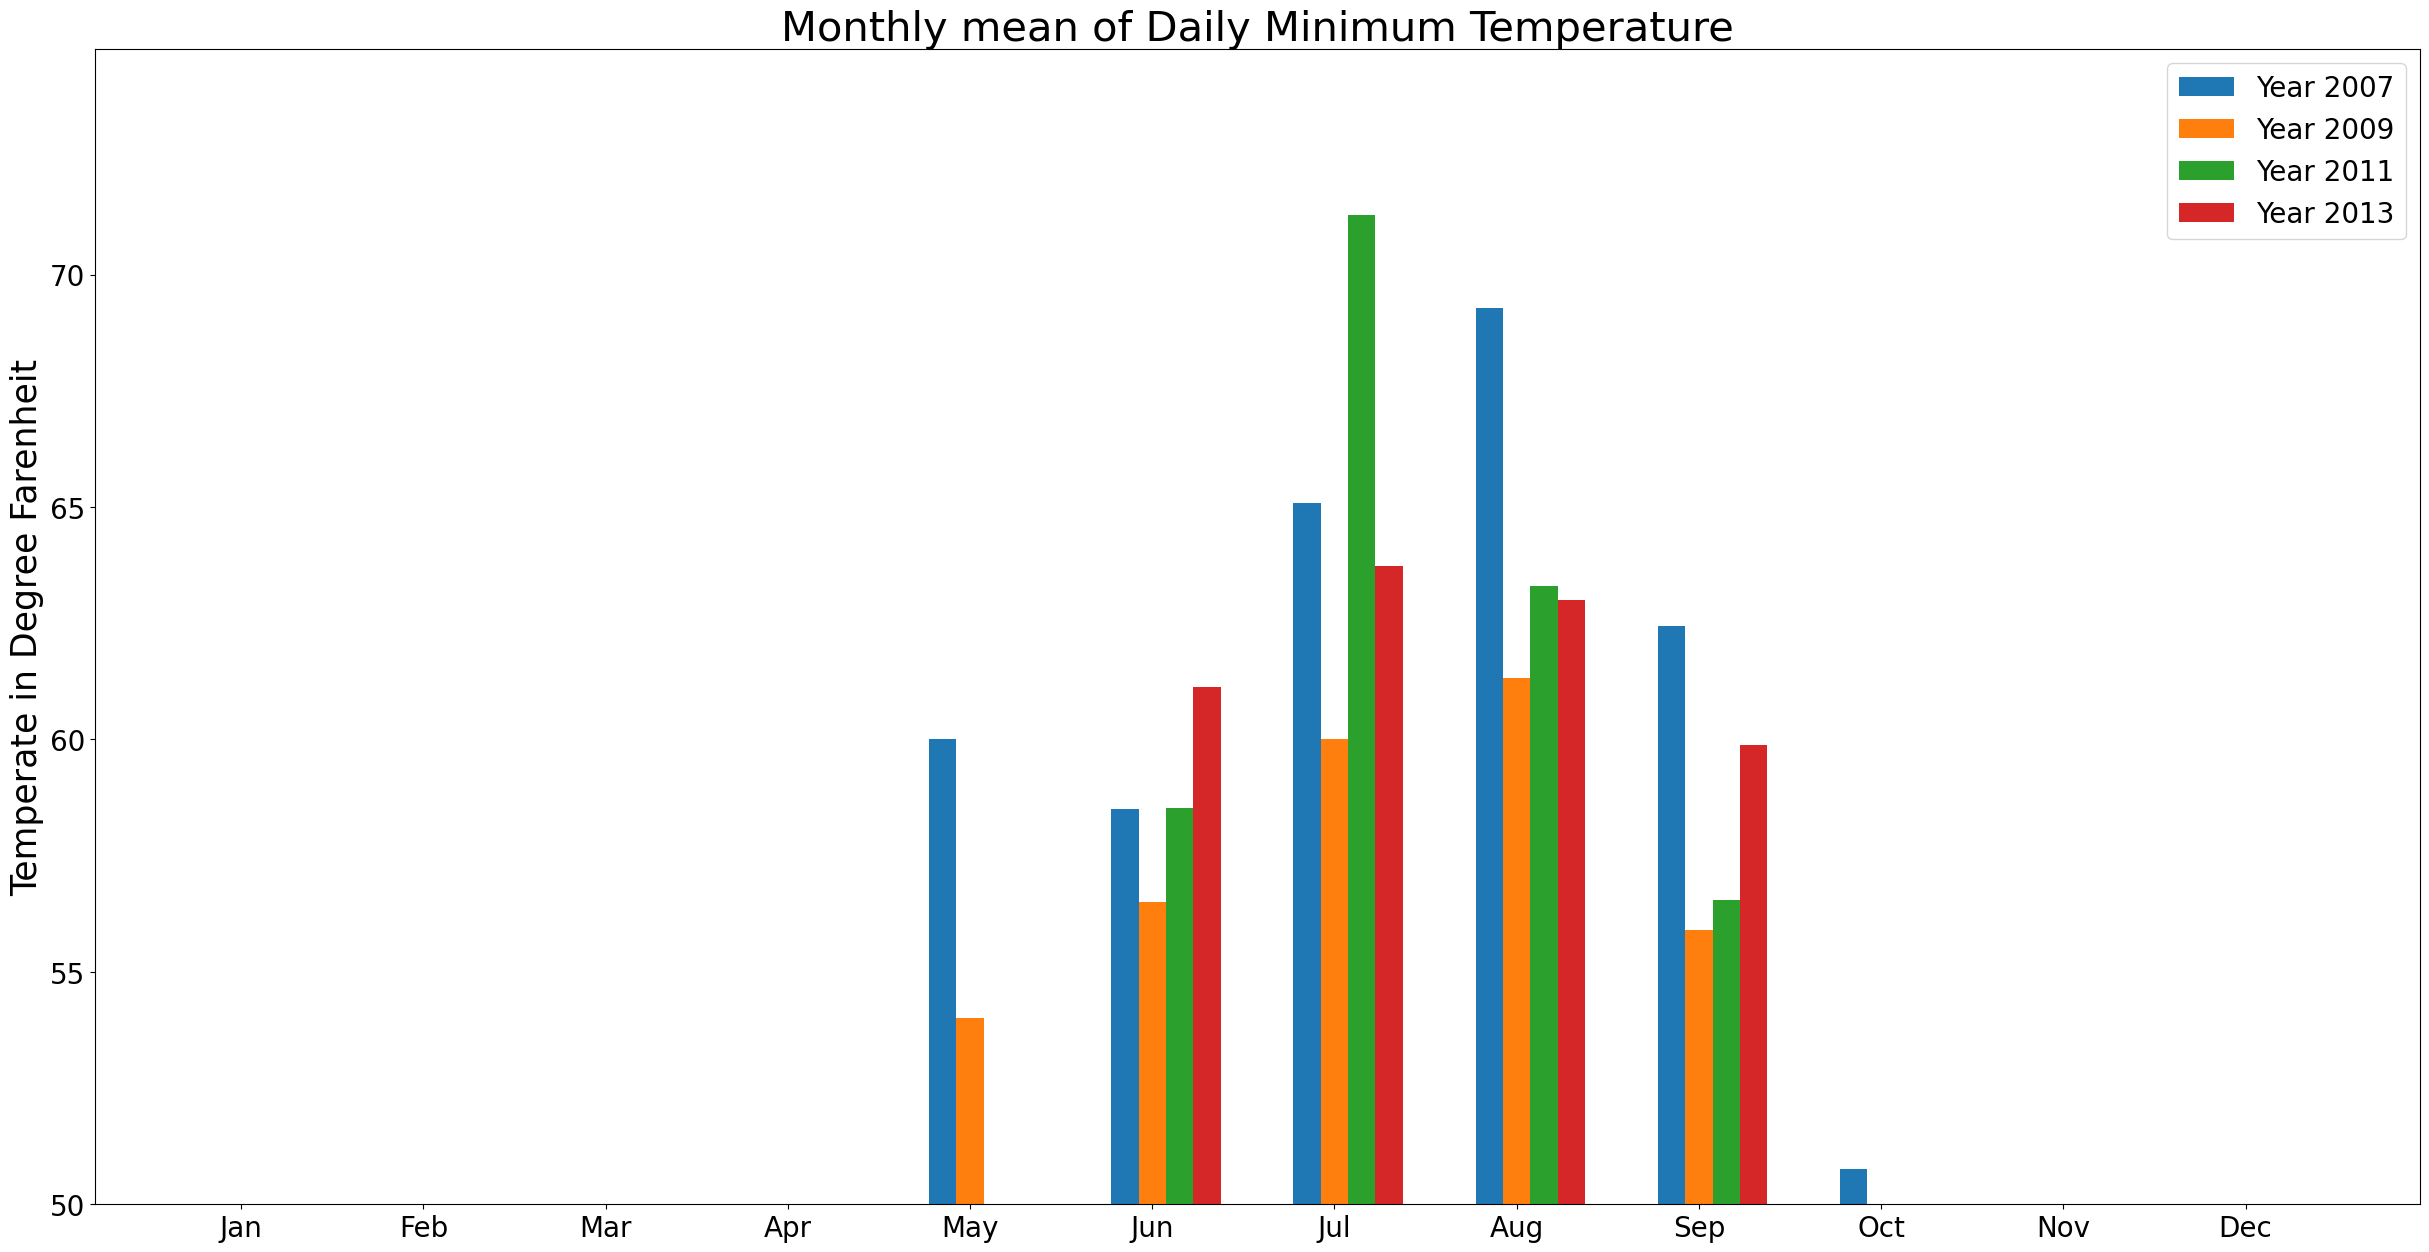

In [30]:
# Group Tmin sequentially by month and by year for barplot visualization

monthly_Tmin_dict = {2007:[], 2009:[], 2011:[], 2013:[]}

for year in [2007,2009,2011,2013]:
    for month in np.arange(1,13):
        condition = monthly_Tmin[(monthly_Tmin['month']==month) & (monthly_Tmin['year']==year)]
        if condition.empty:
            monthly_Tmin_dict[year].append(0)
        else:
            monthly_Tmin_dict[year].append(condition['Tmin'].values[0])

            

# Create dataset
x_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Set the width of the bars
barWidth = 0.15

# Set the positions of the bars on the x-axis
bar_widths = {2007:np.arange(len(monthly_Tmin_dict[2007]))}

for year in [2009,2011,2013]:
    bar_widths[year] = [x + barWidth for x in bar_widths[year-2]]


    

# Create the grouped bar plot
plt.figure(figsize=(30,15))
for year in [2007,2009,2011,2013]:
    plt.bar(bar_widths[year], monthly_Tmin_dict[year], width=barWidth, label=f'Year {year}')


# Add x-axis ticks and labels
plt.xticks([r + barWidth for r in range(len(monthly_Tavg_dict[2007]))], x_labels, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(bottom=50)

# Add y-label
plt.ylabel('Temperate in Degree Farenheit', fontsize=25)

# Add a legend and title
plt.legend(fontsize=20, loc='upper right')
plt.title('Monthly mean of Daily Minimum Temperature', fontsize=30)

# Show the plot
plt.show()

Same pattern in daily minimum temperature: 2007 and 2009 saw temp peaked in Aug while 2011 and 2013 peaked in July

In [31]:
monthly_DewPoint = train_weather.resample('M')['DewPoint'].mean().to_frame()     # .loc[:,'2009']
monthly_DewPoint['month'] = monthly_DewPoint.index.month
monthly_DewPoint['year'] = monthly_DewPoint.index.year

monthly_DewPoint

,DewPoint,month,year
Date,,,
2007-05-31,58.000000,5,2007
2007-06-30,58.181818,6,2007
2007-07-31,59.678261,7,2007
2007-08-31,66.339512,8,2007
2007-09-30,58.062016,9,2007
...,...,...,...
2013-05-31,NaN,5,2013
2013-06-30,57.316514,6,2013
2013-07-31,61.473270,7,2013


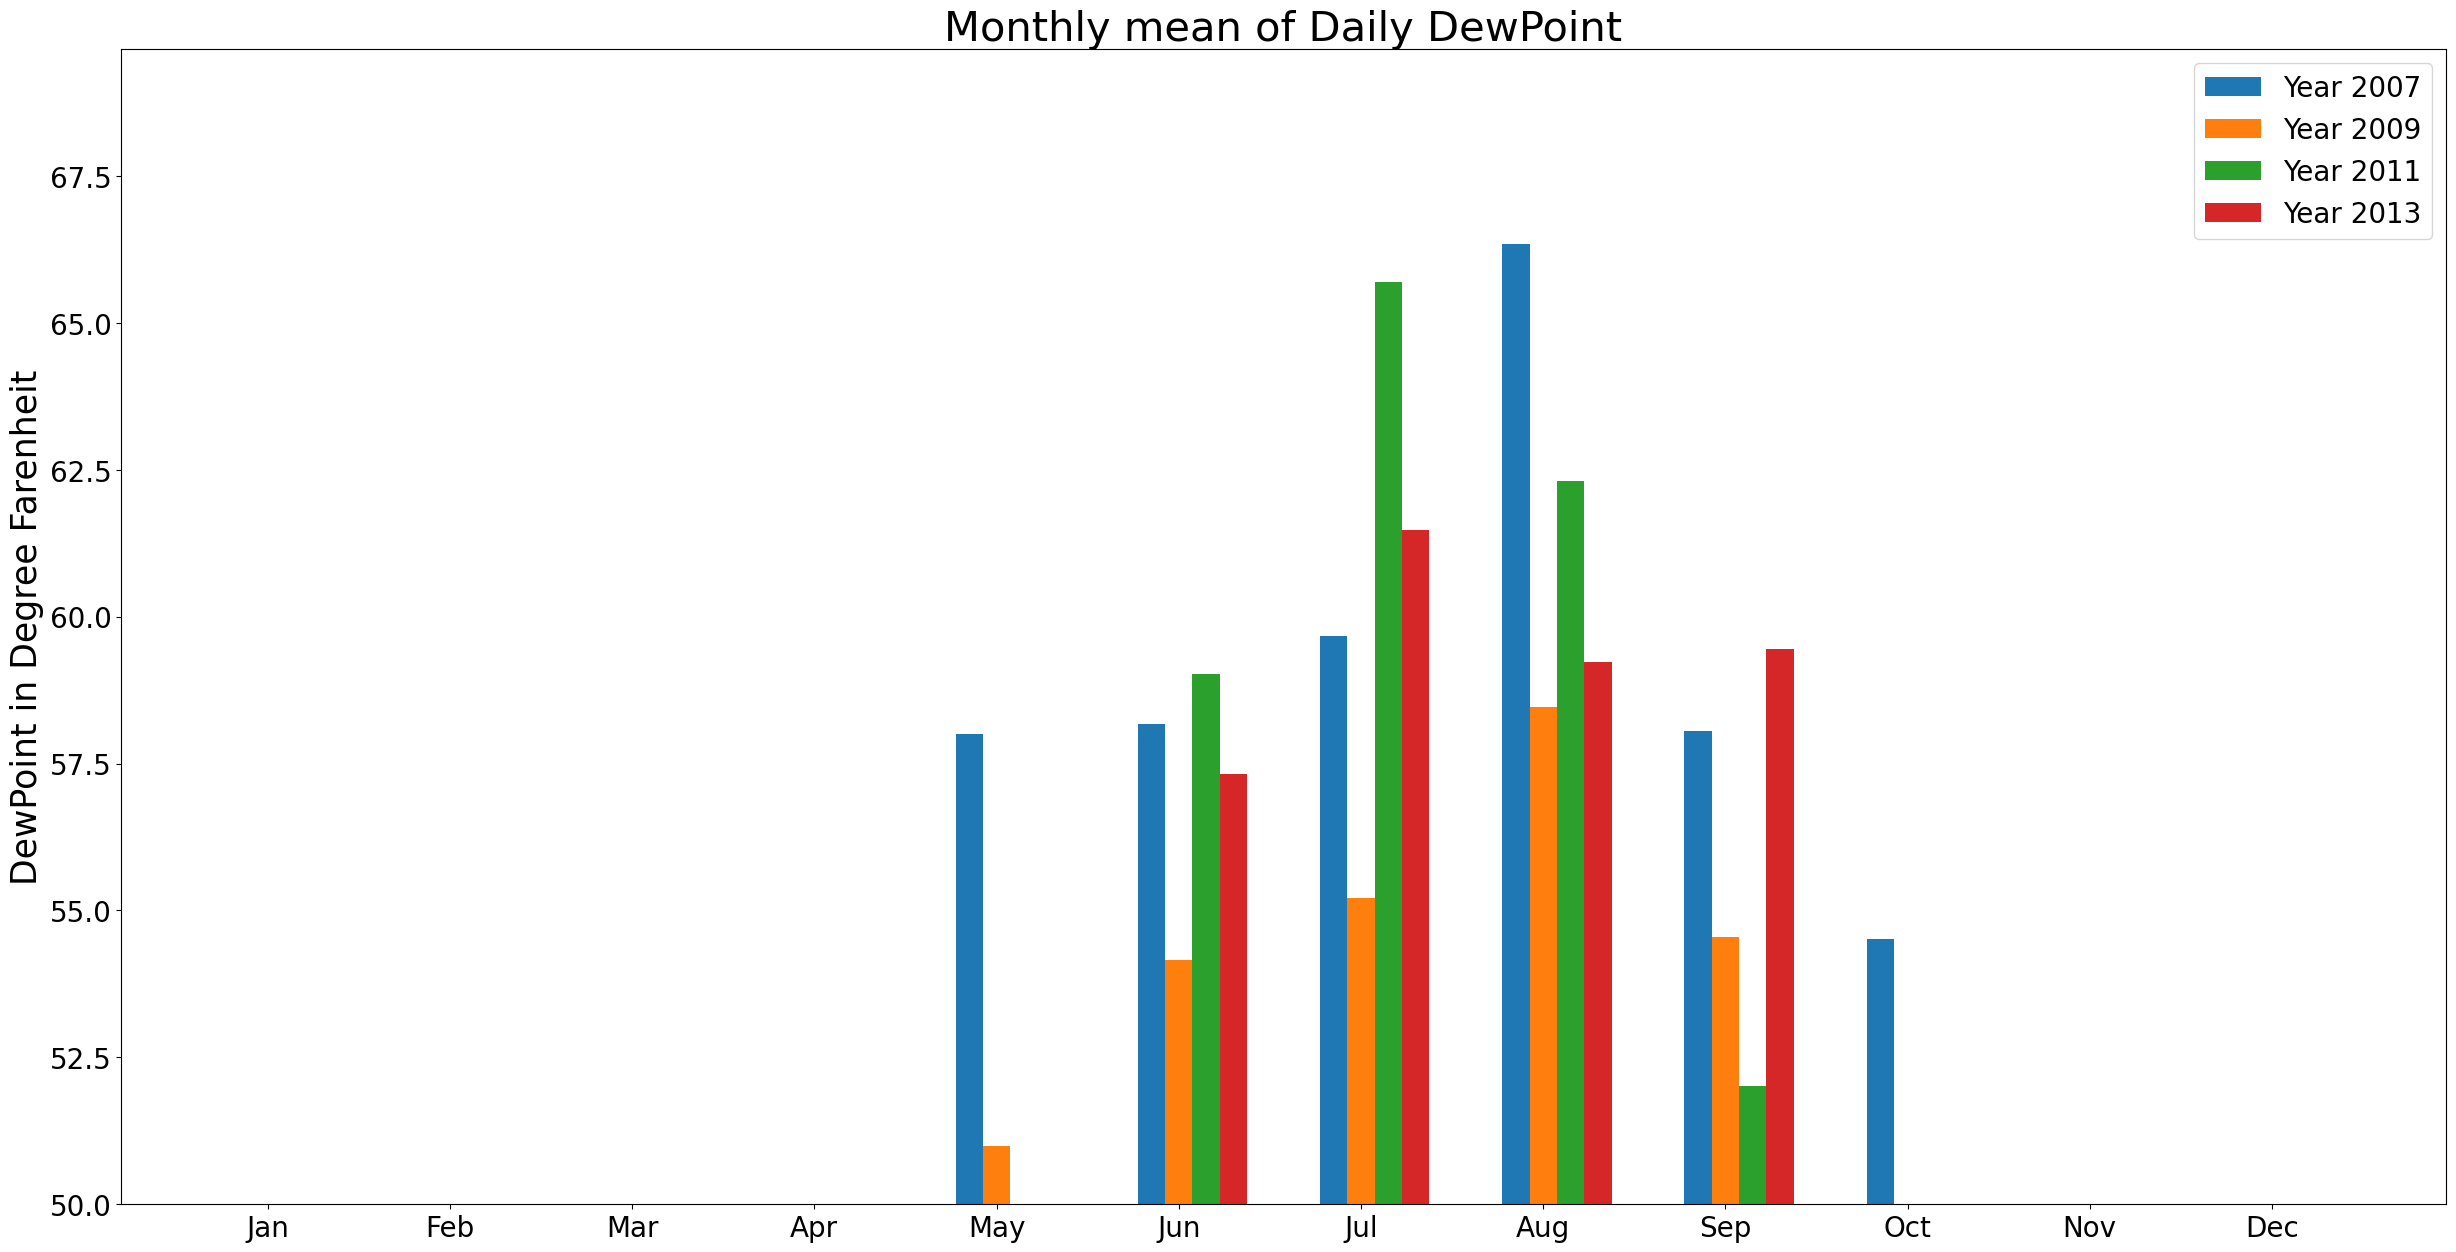

In [32]:
# Group DewPoint sequentially by month and by year for barplot visualization

monthly_DewPoint_dict = {2007:[], 2009:[], 2011:[], 2013:[]}

for year in [2007,2009,2011,2013]:
    for month in np.arange(1,13):
        condition = monthly_DewPoint[(monthly_DewPoint['month']==month) & (monthly_DewPoint['year']==year)]
        if condition.empty:
            monthly_DewPoint_dict[year].append(0)
        else:
            monthly_DewPoint_dict[year].append(condition['DewPoint'].values[0])

            

# Create dataset
x_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Set the width of the bars
barWidth = 0.15

# Set the positions of the bars on the x-axis
bar_widths = {2007:np.arange(len(monthly_DewPoint_dict[2007]))}

for year in [2009,2011,2013]:
    bar_widths[year] = [x + barWidth for x in bar_widths[year-2]]


    

# Create the grouped bar plot
plt.figure(figsize=(30,15))
for year in [2007,2009,2011,2013]:
    plt.bar(bar_widths[year], monthly_DewPoint_dict[year], width=barWidth, label=f'Year {year}')


# Add x-axis ticks and labels
plt.xticks([r + barWidth for r in range(len(monthly_DewPoint_dict[2007]))], x_labels, fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(bottom=50)

# Add y-label
plt.ylabel('DewPoint in Degree Farenheit', fontsize=25)

# Add a legend and title
plt.legend(fontsize=20, loc='upper right')
plt.title('Monthly mean of Daily DewPoint', fontsize=30)

# Show the plot
plt.show()

Same pattern in DewPoint: 2007 and 2009 saw temp peaked in Aug while 2011 and 2013 peaked in July

## Weekly Trend Analysis

In [33]:
weekly_Wnv = train_weather.resample('W')['WnvPresent'].sum().to_frame()     # .loc[:,'2009']
weekly_Wnv['week'] = weekly_Wnv.index.week
weekly_Wnv['year'] = weekly_Wnv.index.year

weekly_Wnv

C:\Users\samue\AppData\Local\Temp\ipykernel_16536\286662678.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weekly_Wnv['week'] = weekly_Wnv.index.week


,WnvPresent,week,year
Date,,,
2007-06-03,0,22,2007
2007-06-10,0,23,2007
2007-06-17,0,24,2007
2007-06-24,0,25,2007
2007-07-01,0,26,2007
...,...,...,...
2013-09-01,38,35,2013
2013-09-08,32,36,2013
2013-09-15,23,37,2013


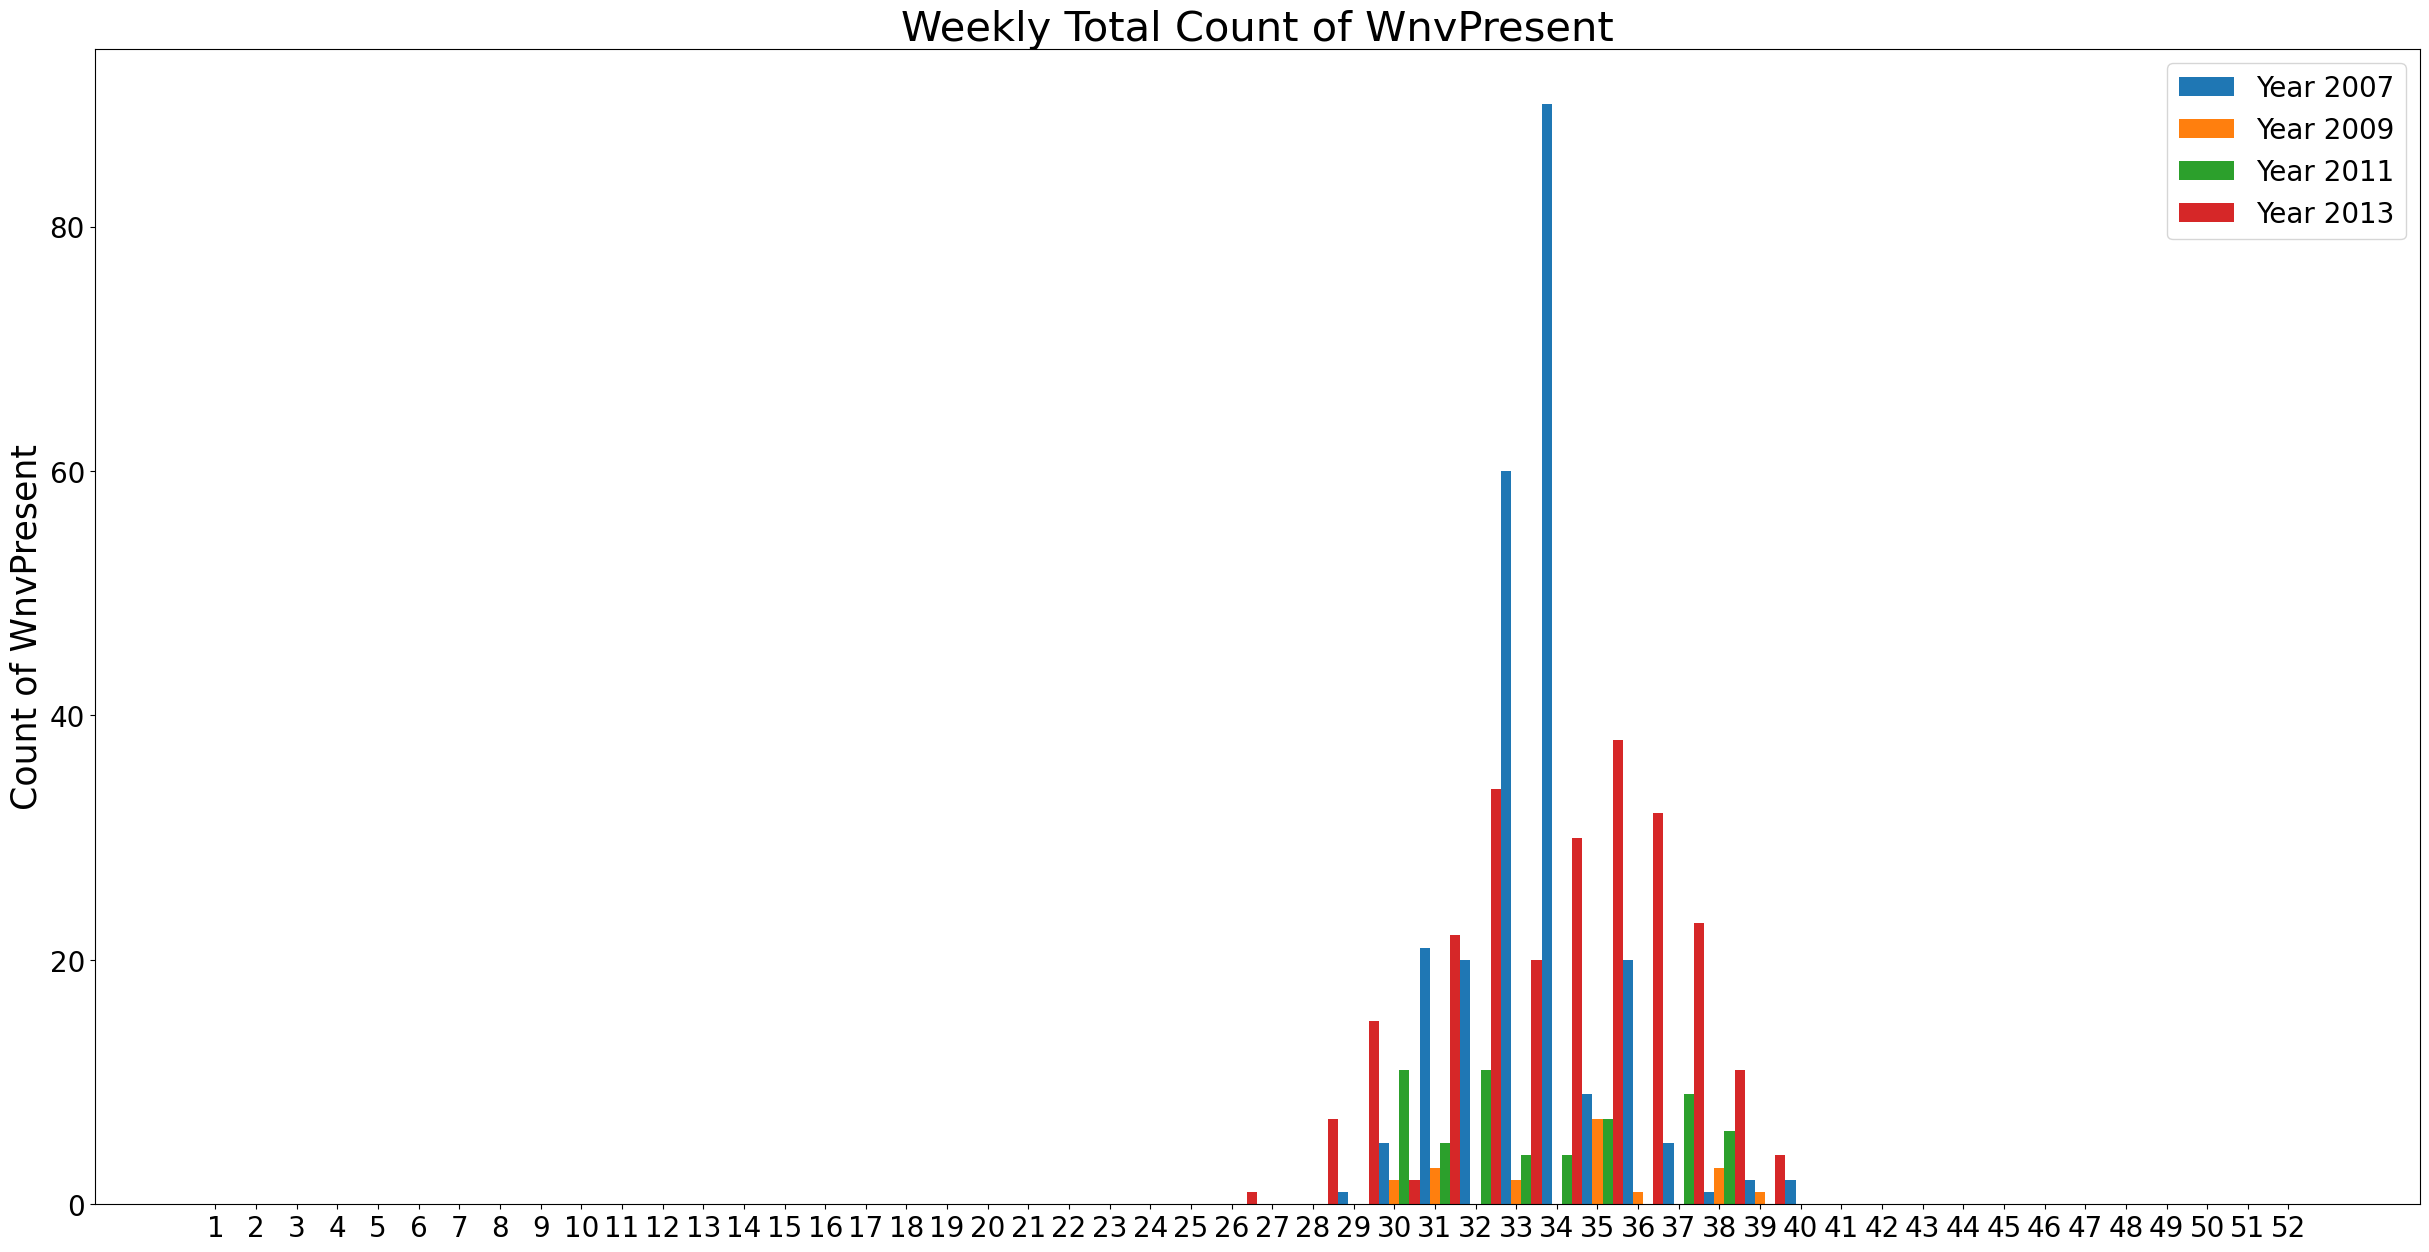

In [34]:
# Group WnvPresent sequentially by week and by year for barplot visualization

weeks = np.arange(1,53)
weekly_Wnv_dict = {2007:[], 2009:[], 2011:[], 2013:[]}


for year in [2007,2009,2011,2013]:
    for week in weeks:
        condition = weekly_Wnv[(weekly_Wnv['week']==week) & (weekly_Wnv['year']==year)]
        if condition.empty:
            weekly_Wnv_dict[year].append(0)
        else:
            weekly_Wnv_dict[year].append(condition['WnvPresent'].values[0])

            

# Create dataset
x_labels = weeks

# Set the width of the bars
barWidth = 0.25

# Set the positions of the bars on the x-axis
bar_widths = {2007:np.arange(len(weekly_Wnv_dict[2007]))}

for year in [2009,2011,2013]:
    bar_widths[year] = [x + barWidth for x in bar_widths[year-2]]


    

# Create the grouped bar plot
plt.figure(figsize=(30,15))
for year in [2007,2009,2011,2013]:
    plt.bar(bar_widths[year], weekly_Wnv_dict[year], width=barWidth, label=f'Year {year}')


# Add x-axis ticks and labels
plt.xticks([r + barWidth for r in range(len(weekly_Wnv_dict[2007]))], x_labels, fontsize=20)
plt.yticks(fontsize=20)

# Add y-label
plt.ylabel('Count of WnvPresent', fontsize=25)

# Add a legend and title
plt.legend(fontsize=20, loc='upper right')
plt.title('Weekly Total Count of WnvPresent', fontsize=30)

# Show the plot
plt.show()


# We can see here that the spike in WnvPresent total count tends to happen in week 33-34 (August)

In [35]:
weekly_Tavg = train_weather.resample('W')['Tavg'].mean().to_frame()     # .loc[:,'2009']
weekly_Tavg['week'] = weekly_Tavg.index.week
weekly_Tavg['year'] = weekly_Tavg.index.year

weekly_Tavg

C:\Users\samue\AppData\Local\Temp\ipykernel_16536\3302845201.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weekly_Tavg['week'] = weekly_Tavg.index.week


,Tavg,week,year
Date,,,
2007-06-03,74.000000,22,2007
2007-06-10,55.500000,23,2007
2007-06-17,NaN,24,2007
2007-06-24,NaN,25,2007
2007-07-01,73.862069,26,2007
...,...,...,...
2013-09-01,77.500000,35,2013
2013-09-08,71.500000,36,2013
2013-09-15,72.000000,37,2013


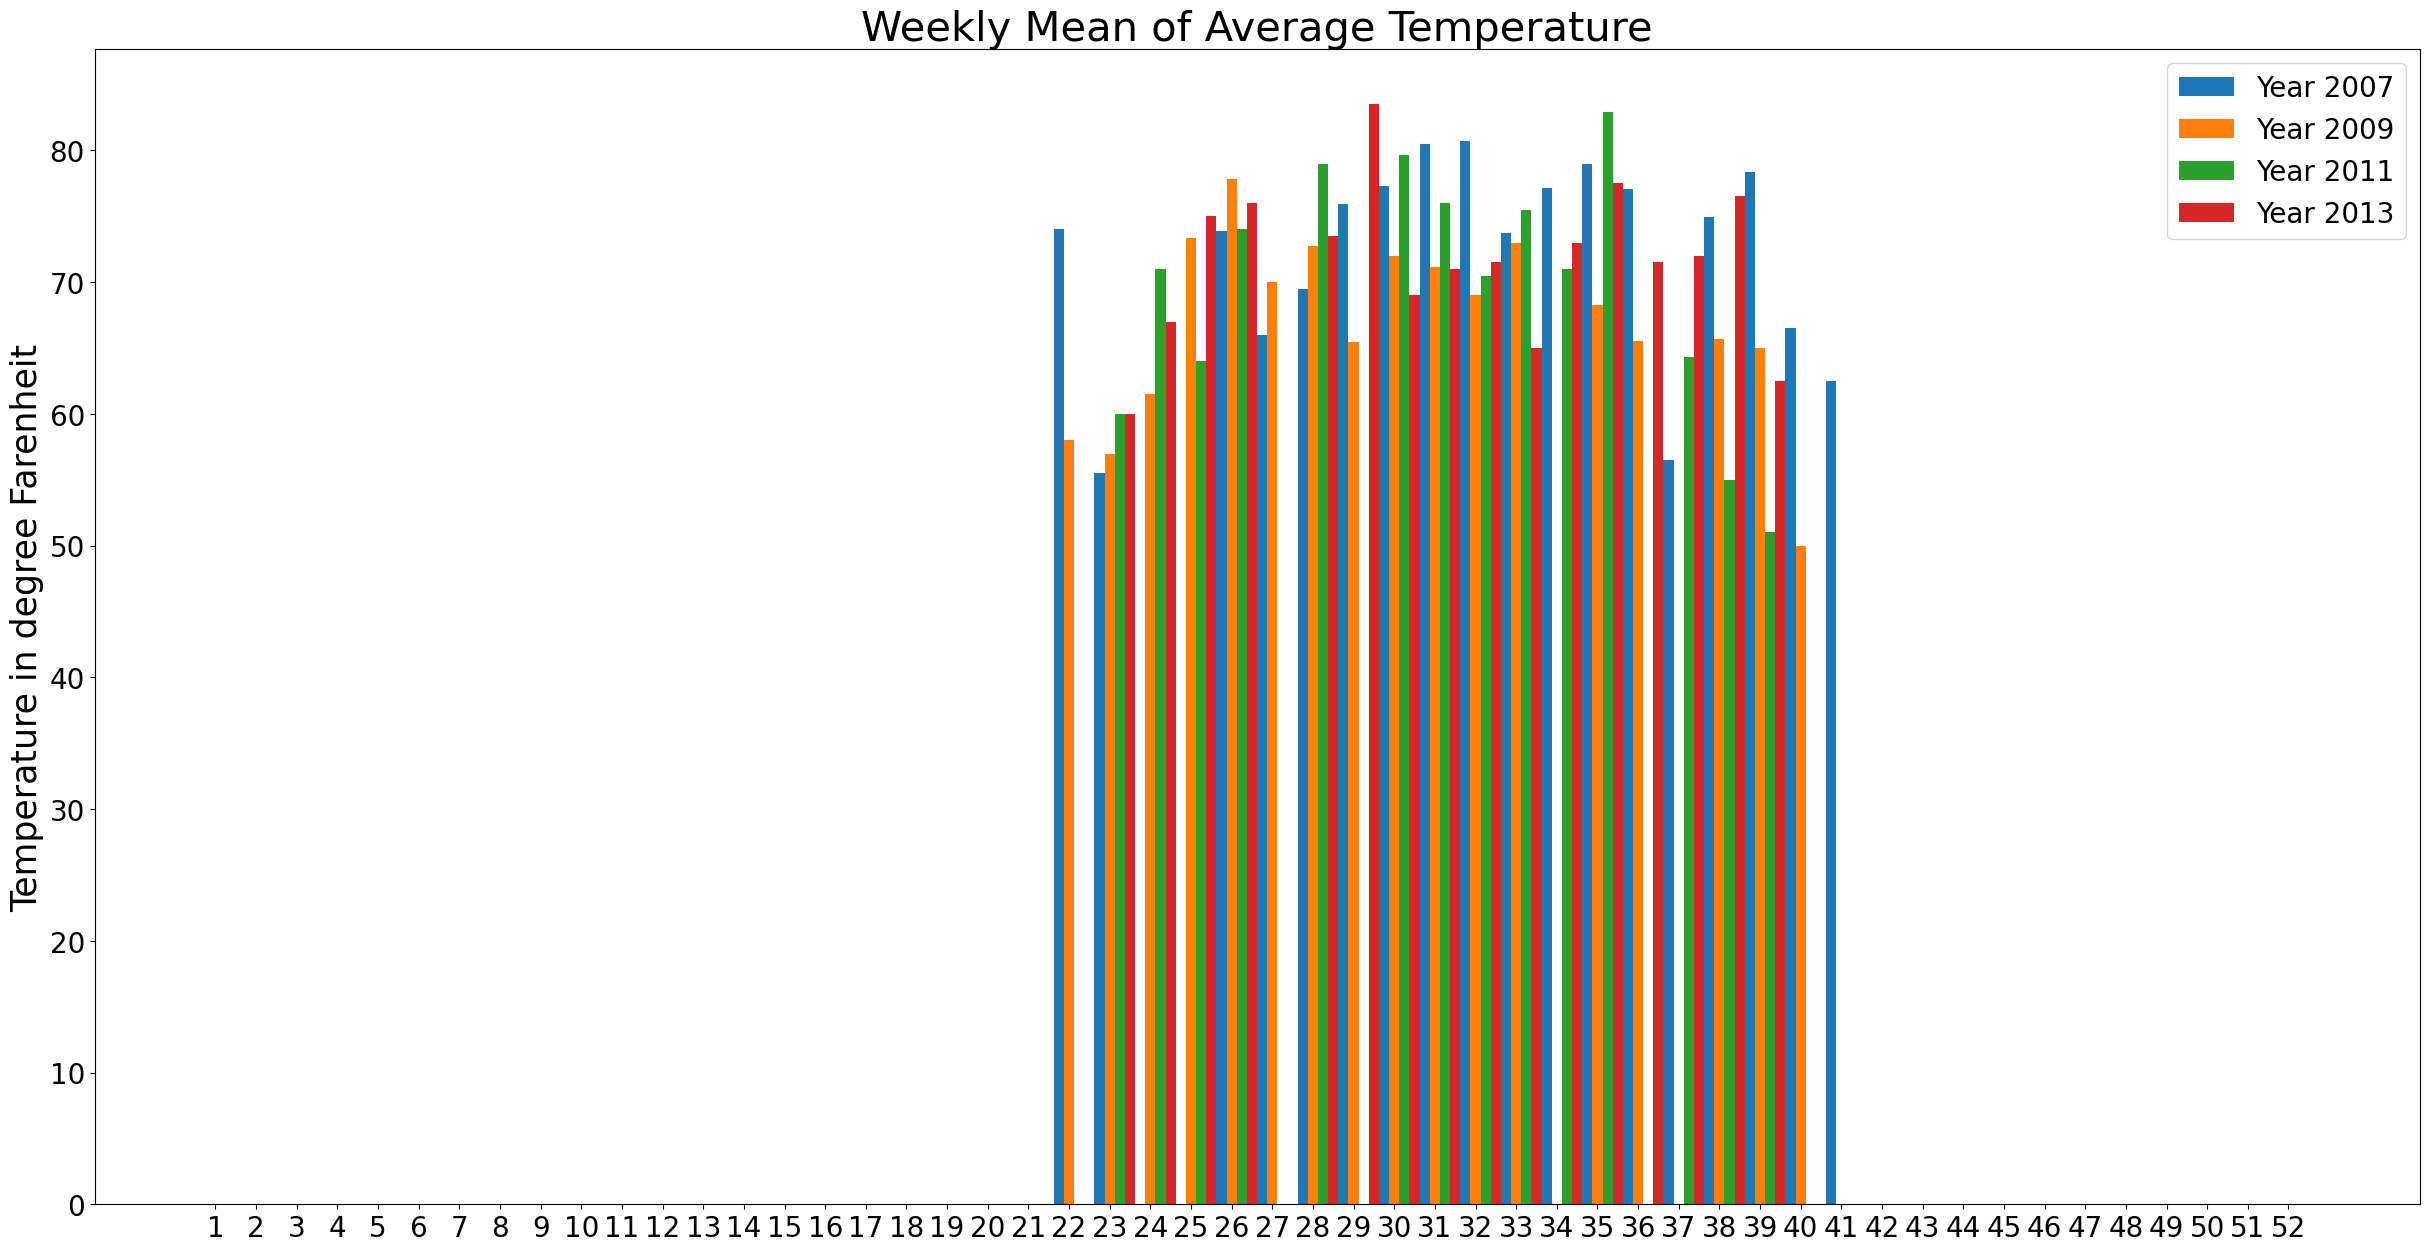

In [36]:
# Group Tavg sequentially by week and by year for barplot visualization

weeks = np.arange(1,53)
weekly_Tavg_dict = {2007:[], 2009:[], 2011:[], 2013:[]}


for year in [2007,2009,2011,2013]:
    for week in weeks:
        condition = weekly_Tavg[(weekly_Tavg['week']==week) & (weekly_Tavg['year']==year)]
        if condition.empty:
            weekly_Tavg_dict[year].append(0)
        else:
            weekly_Tavg_dict[year].append(condition['Tavg'].values[0])

            

# Create dataset
x_labels = weeks

# Set the width of the bars
barWidth = 0.25

# Set the positions of the bars on the x-axis
bar_widths = {2007:np.arange(len(weekly_Tavg_dict[2007]))}

for year in [2009,2011,2013]:
    bar_widths[year] = [x + barWidth for x in bar_widths[year-2]]


    

# Create the grouped bar plot
plt.figure(figsize=(30,15))
for year in [2007,2009,2011,2013]:
    plt.bar(bar_widths[year], weekly_Tavg_dict[year], width=barWidth, label=f'Year {year}')


# Add x-axis ticks and labels
plt.xticks([r + barWidth for r in range(len(weekly_Tavg_dict[2007]))], x_labels, fontsize=20)
plt.yticks(fontsize=20)

# Add y-label
plt.ylabel('Temperature in degree Farenheit', fontsize=25)

# Add a legend and title
plt.legend(fontsize=20, loc='upper right')
plt.title('Weekly Mean of Average Temperature', fontsize=30)

# Show the plot
plt.show()


## Correlation Analysis

In [37]:
train_weather.columns

Index(['WnvPresent', 'NumMosquitos', 'Longitude', 'Latitude', 'Tmax', 'Tmin',
       'Tavg', 'DewPoint', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'ResultSpeed',
       'ResultDir', 'AvgSpeed'],
      dtype='object')

In [38]:
# Convert 'object' columns to float dtype
for col in train_weather.columns:
    if train_weather[col].dtype=='object':
        train_weather[col] = train_weather[col].astype(float)
        
train_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   WnvPresent    10506 non-null  int64  
 1   NumMosquitos  10506 non-null  int64  
 2   Longitude     10506 non-null  float64
 3   Latitude      10506 non-null  float64
 4   Tmax          10506 non-null  int64  
 5   Tmin          10506 non-null  int64  
 6   Tavg          10506 non-null  float64
 7   DewPoint      10506 non-null  int64  
 8   Heat          10506 non-null  float64
 9   Cool          10506 non-null  float64
 10  Sunrise       10506 non-null  float64
 11  Sunset        10506 non-null  float64
 12  ResultSpeed   10506 non-null  float64
 13  ResultDir     10506 non-null  int64  
 14  AvgSpeed      10506 non-null  float64
dtypes: float64(9), int64(6)
memory usage: 1.3 MB


In [39]:
df = train_weather.groupby('Date').mean()
df.describe()

,WnvPresent,NumMosquitos,Longitude,Latitude,Tmax,Tmin,Tavg,DewPoint,Heat,Cool,Sunrise,Sunset,ResultSpeed,ResultDir,AvgSpeed
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,0.041470,13.131741,-87.698540,41.838018,80.642105,61.536842,71.089474,58.747368,1.357895,7.652632,467.673684,1870.610526,6.315789,17.442105,7.776842
std,0.061310,10.590964,0.059467,0.064107,8.884502,8.218830,8.052348,8.356382,3.417464,5.736721,48.344386,66.228215,2.925577,9.945293,2.581994
min,0.000000,1.600000,-87.896384,41.686398,57.000000,41.000000,50.000000,39.000000,0.000000,0.000000,416.000000,1720.000000,0.100000,1.000000,2.100000
25%,0.000000,6.135018,-87.722916,41.838682,77.000000,57.000000,66.250000,54.000000,0.000000,1.500000,422.000000,1826.500000,4.050000,7.500000,5.900000
50%,0.011976,9.673913,-87.712321,41.854358,83.000000,63.000000,73.000000,59.000000,0.000000,8.000000,447.000000,1909.000000,5.900000,19.000000,7.400000
75%,0.058986,15.651321,-87.693333,41.868679,87.000000,69.000000,77.500000,66.000000,0.000000,13.000000,517.500000,1926.000000,8.250000,25.000000,9.500000
max,0.265734,48.978495,-87.531635,41.972276,96.000000,76.000000,84.000000,73.000000,15.000000,19.000000,557.000000,1931.000000,14.600000,36.000000,15.000000


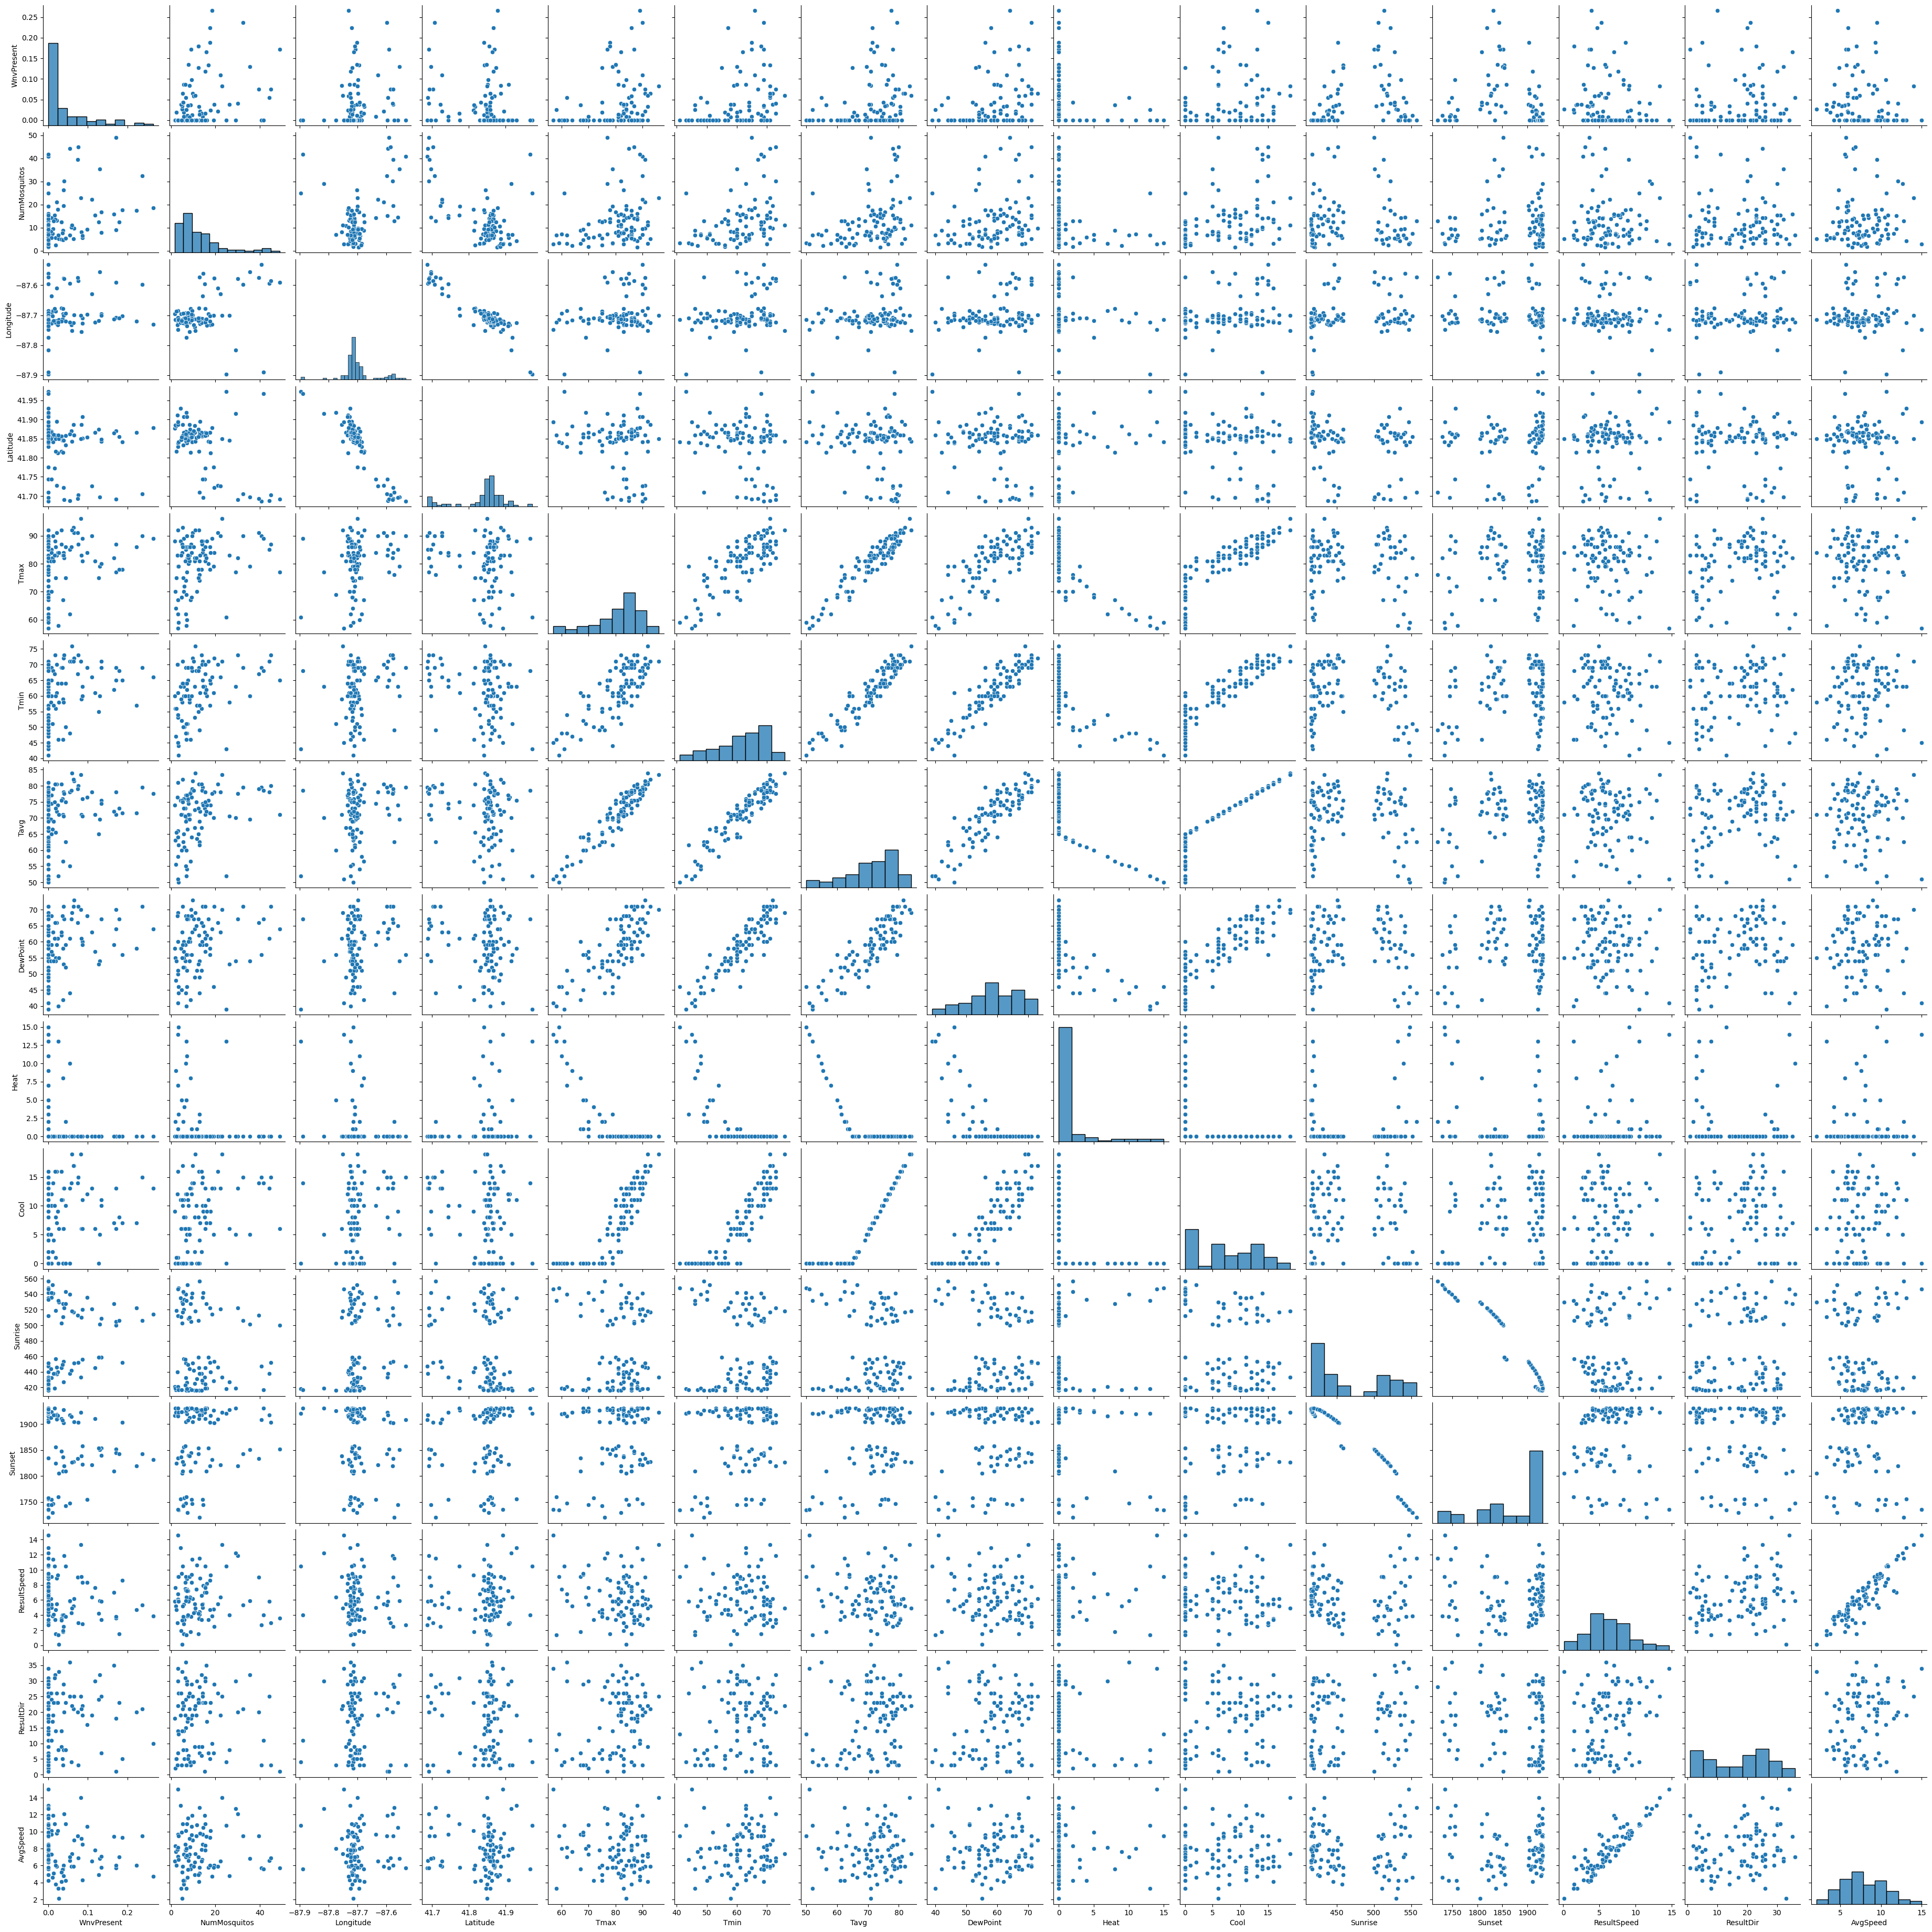

In [40]:
sns.pairplot(df)

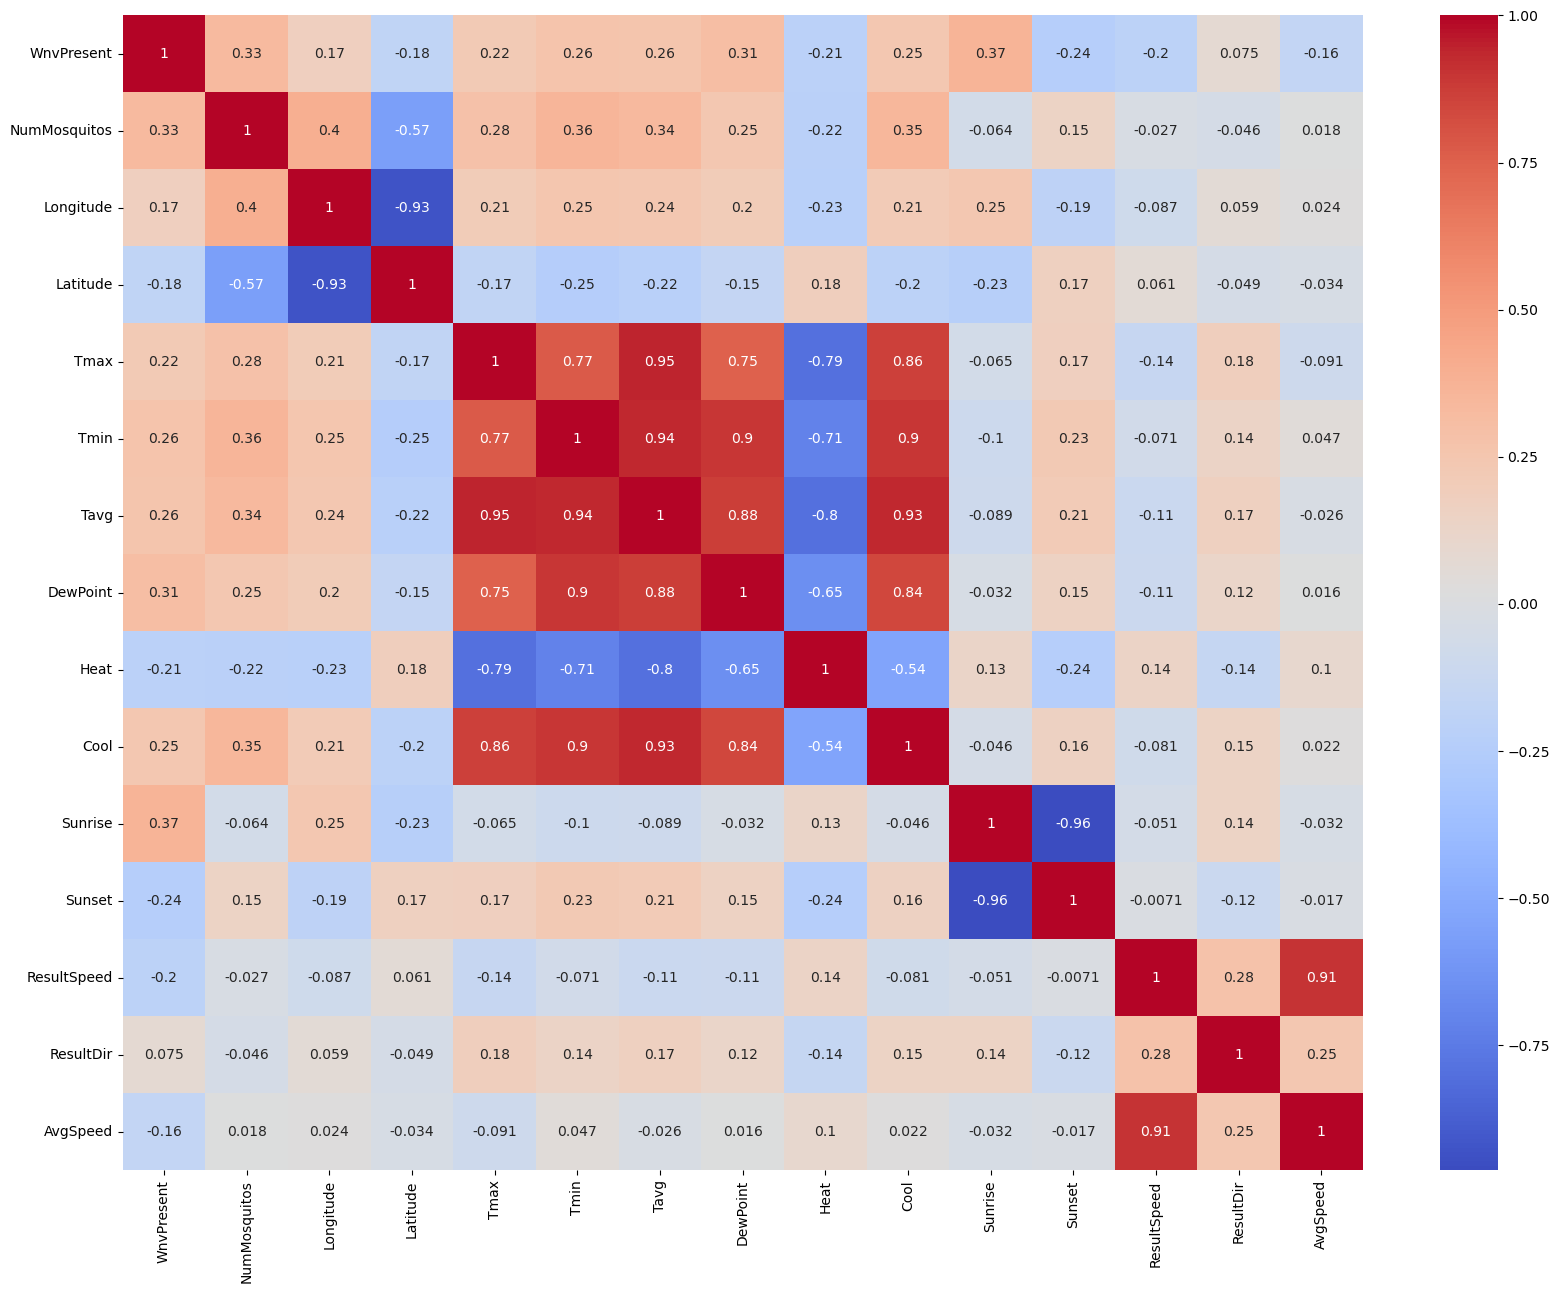

In [41]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True);

# Daily mean total NumMosquitos is quite positively correlated with WnvPresent of +0.33
# Among the Temperature features, Tmin has higher positive corr with NumMosquitos of +0.36; Tavg has +0.34
# Tmin and Tavg has same +0.26 corr with WnvPresent; Interestingly, DewPoint has the highest +0.31 with WnvPresent
# Windspeed features are relatively weakly correlated with both WnvPresent and NumMosquitos

## Time Series Analysis of Temperature

In [42]:
from statsmodels.graphics.tsaplots import plot_pacf

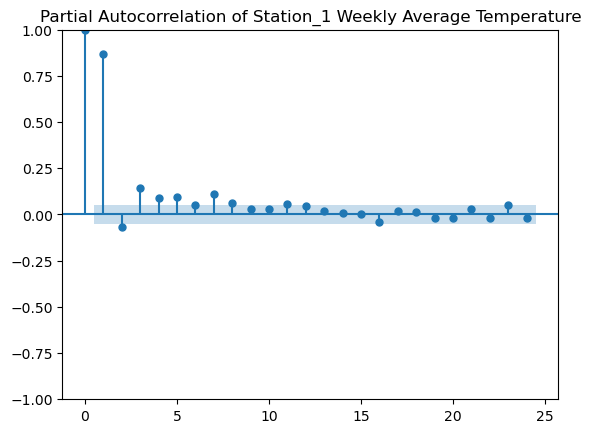

In [43]:
temp_df = station_1_weather['Tavg']

plot_pacf(temp_df, lags=24, method='ywm')
plt.title('Partial Autocorrelation of Station_1 Weekly Average Temperature');


# No need to difference the data as temperature readings appear to be stationary already
# Linear dependence of lag plots can be captured using lags 1,2,3,4,5

In [44]:
# Define function to make lags in time series

def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i) for i in range(0, lags+1)
        },
        axis=1)

In [45]:
# Create new dataframe with Tavg and its lags
temp_with_lags = make_lags(temp_df, 5)
temp_with_lags.fillna(0.0, inplace=True)
temp_with_lags.head(10)

,y_lag_0,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5
Date,,,,,,
2007-05-01,66.5,0.0,0.0,0.0,0.0,0.0
2007-05-02,50.5,66.5,0.0,0.0,0.0,0.0
2007-05-03,56.0,50.5,66.5,0.0,0.0,0.0
2007-05-04,57.5,56.0,50.5,66.5,0.0,0.0
2007-05-05,59.5,57.5,56.0,50.5,66.5,0.0
2007-05-06,58.5,59.5,57.5,56.0,50.5,66.5
2007-05-07,65.0,58.5,59.5,57.5,56.0,50.5
2007-05-08,68.0,65.0,58.5,59.5,57.5,56.0
2007-05-09,69.0,68.0,65.0,58.5,59.5,57.5


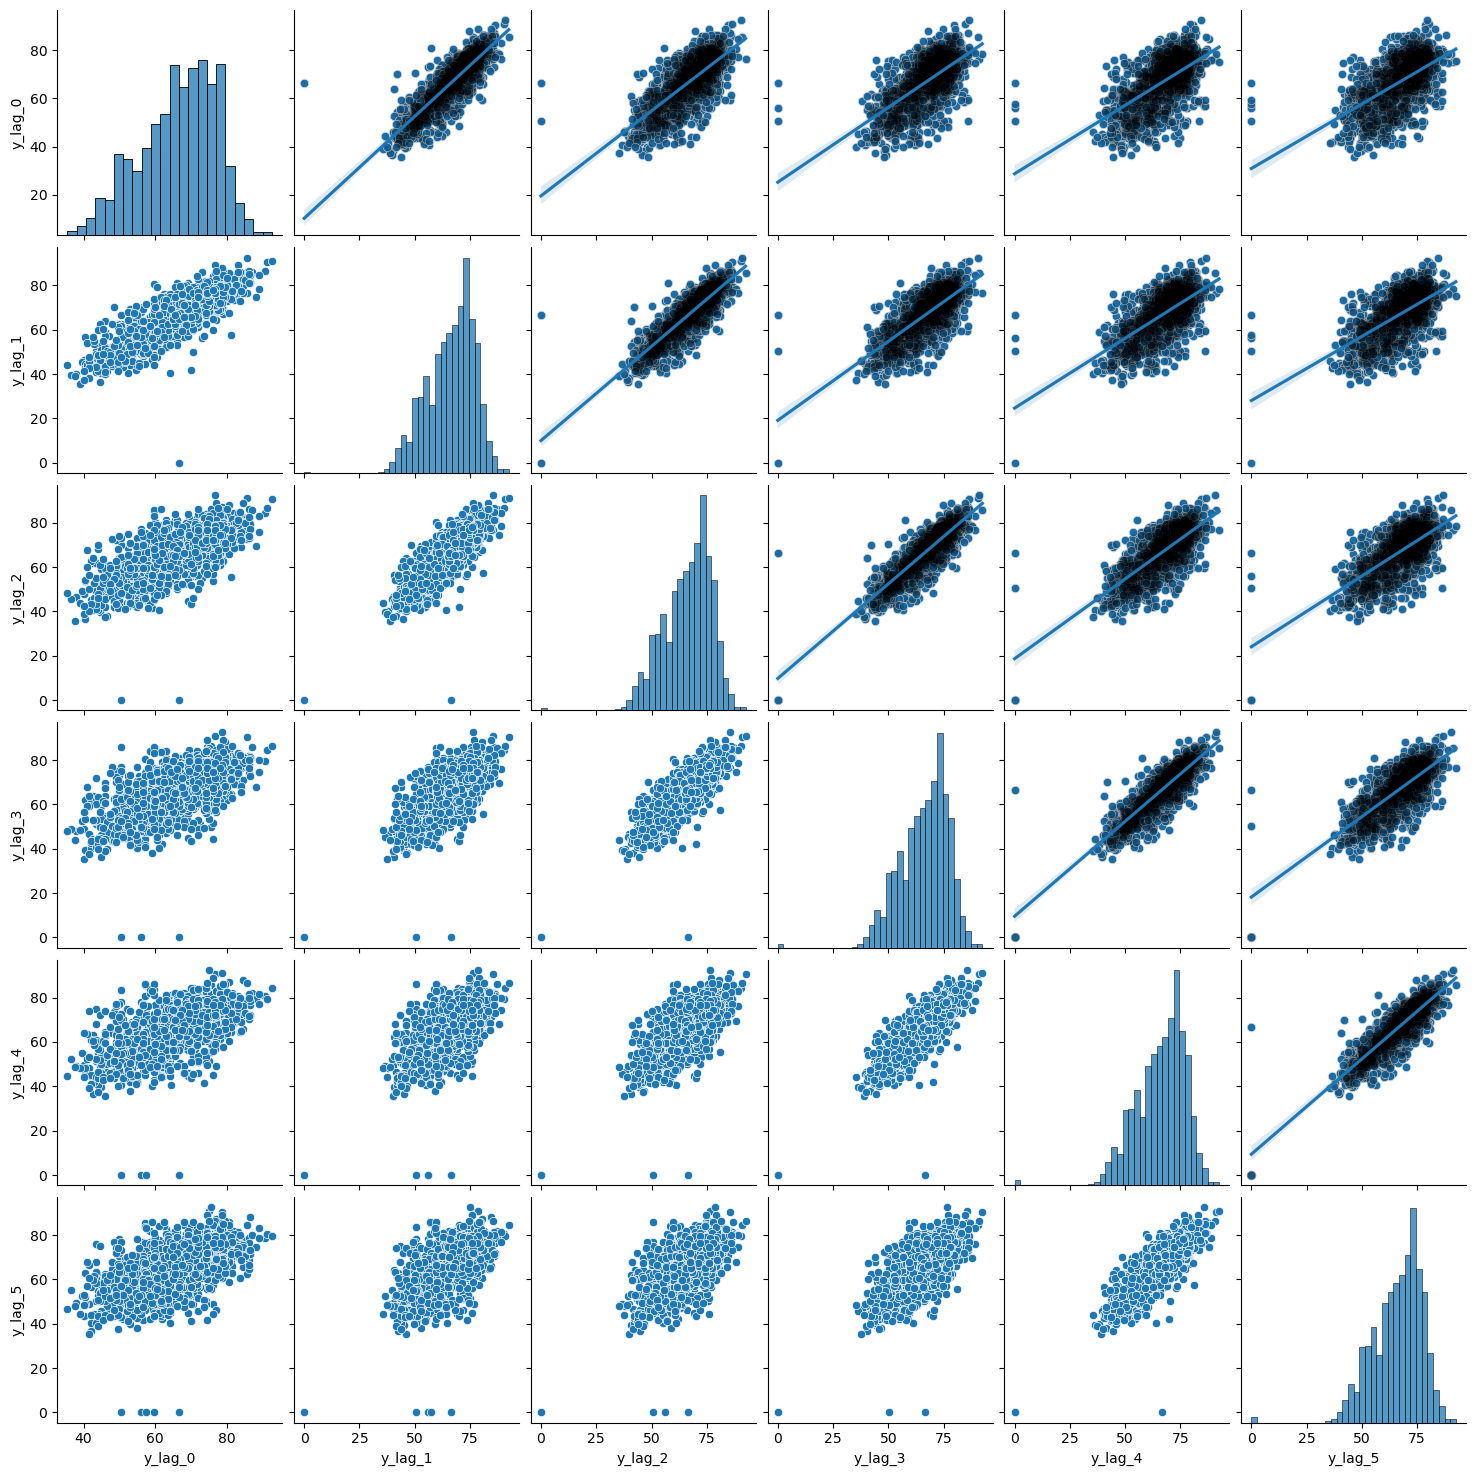

In [46]:
# Make a regression plot of Tavg and its lags 1,2,3,4,5

pairplot = sns.pairplot(temp_with_lags)

# Add a linear regression line plot to the pairplot
for i, j in zip(*np.triu_indices_from(pairplot.axes, 1)):
    pairplot.axes[i, j].scatter(temp_with_lags.iloc[:, j], temp_with_lags.iloc[:, i], color='black', alpha=.08)
    sns.regplot(x=temp_with_lags.iloc[:, j], y=temp_with_lags.iloc[:, i], scatter=False, ax=pairplot.axes[i, j])

plt.show()

From this pairplot chart, we can see that Tavg has strong positive correlation with its time lags of up to 4 days

In [47]:
# Create new dataframe with weekly Tavg and its lags
weekly_temp_df = station_1_weather.groupby('YearWeek')['Tavg'].mean()
weekly_temp_lags = make_lags(weekly_temp_df, 5)
weekly_temp_lags.fillna(0.0, inplace=True)
weekly_temp_lags.head(10)

# Rename col headers to more relevant names
weekly_temp_lags.columns = ['weekly_Tavg', 'weekly_Tavg_lag_1', 'weekly_Tavg_lag_2', 'weekly_Tavg_lag_3', 'weekly_Tavg_lag_4', 'weekly_Tavg_lag_5' ]

weekly_temp_lags

,weekly_Tavg,weekly_Tavg_lag_1,weekly_Tavg_lag_2,weekly_Tavg_lag_3,weekly_Tavg_lag_4,weekly_Tavg_lag_5
YearWeek,,,,,,
200718,58.083333,0.000000,0.000000,0.000000,0.000000,0.000000
200719,63.357143,58.083333,0.000000,0.000000,0.000000,0.000000
200720,61.357143,63.357143,58.083333,0.000000,0.000000,0.000000
200721,67.000000,61.357143,63.357143,58.083333,0.000000,0.000000
200722,71.857143,67.000000,61.357143,63.357143,58.083333,0.000000
...,...,...,...,...,...,...
201440,55.500000,63.785714,61.214286,58.714286,73.071429,76.500000
201441,51.714286,55.500000,63.785714,61.214286,58.714286,73.071429
201442,52.428571,51.714286,55.500000,63.785714,61.214286,58.714286


## Calculating Relative Humidity

In [48]:
humidity_df = station_1_weather[['Tavg','DewPoint']]
humidity_df.head(10)

,Tavg,DewPoint
Date,,
2007-05-01,66.5,51
2007-05-02,50.5,42
2007-05-03,56.0,40
2007-05-04,57.5,41
2007-05-05,59.5,38
2007-05-06,58.5,30
2007-05-07,65.0,41
2007-05-08,68.0,58
2007-05-09,69.0,59


In [49]:
# Convert both cols to degree Celsius

humidity_df['Tavg'] = (humidity_df['Tavg'].loc[:]-32)*5/9
humidity_df['DewPoint'] = (humidity_df['DewPoint']-32)*5/9
humidity_df

C:\Users\samue\AppData\Local\Temp\ipykernel_16536\3697243911.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humidity_df['Tavg'] = (humidity_df['Tavg'].loc[:]-32)*5/9
C:\Users\samue\AppData\Local\Temp\ipykernel_16536\3697243911.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humidity_df['DewPoint'] = (humidity_df['DewPoint']-32)*5/9


,Tavg,DewPoint
Date,,
2007-05-01,19.166667,10.555556
2007-05-02,10.277778,5.555556
2007-05-03,13.333333,4.444444
2007-05-04,14.166667,5.000000
2007-05-05,15.277778,3.333333
...,...,...
2014-10-27,17.777778,10.555556
2014-10-28,13.611111,3.333333
2014-10-29,5.833333,0.000000


In [50]:
# Define function calculate Relative Humidity

def calculate_rh(temp_c, dewpoint_c):
    """Calculate relative humidity given temperature and dew point in degree celsius"""
    numerator = np.exp((17.625*dewpoint_c)/(243.04+dewpoint_c))
    denominator = np.exp((17.625*temp_c)/(243.04+temp_c))
    rh = 100 * (numerator/denominator)
    return rh
    

In [51]:
# Create a column for relative humidity rh

humidity_df['rh'] = humidity_df.apply(lambda row: calculate_rh(row['Tavg'], row['DewPoint']), axis=1) 
humidity_df

C:\Users\samue\AppData\Local\Temp\ipykernel_16536\3809529771.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  humidity_df['rh'] = humidity_df.apply(lambda row: calculate_rh(row['Tavg'], row['DewPoint']), axis=1)


,Tavg,DewPoint,rh
Date,,,
2007-05-01,19.166667,10.555556,57.422798
2007-05-02,10.277778,5.555556,72.526813
2007-05-03,13.333333,4.444444,54.874919
2007-05-04,14.166667,5.000000,54.038112
2007-05-05,15.277778,3.333333,44.756109
...,...,...,...
2014-10-27,17.777778,10.555556,62.642016
2014-10-28,13.611111,3.333333,49.844776
2014-10-29,5.833333,0.000000,66.158834


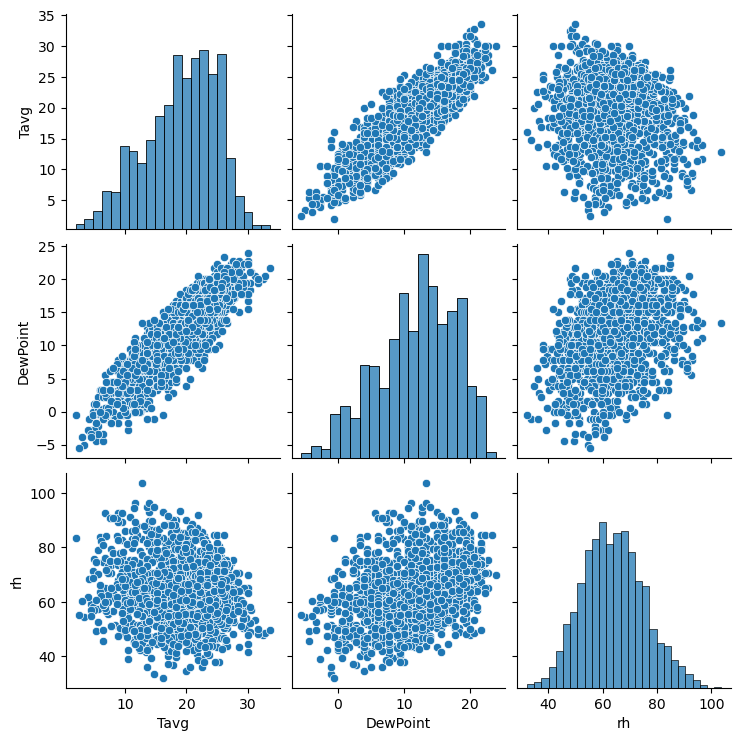

In [52]:
sns.pairplot(humidity_df)

# Use relative humidity instead of DewPoint as it is much less correlated with Tavg

## Time Series Analysis of Relative Humidity

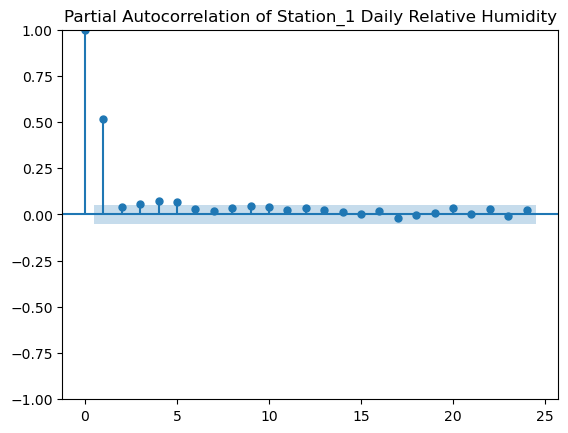

In [53]:
# Plot PACF to check how many lags is needed

plot_pacf(humidity_df['rh'], lags=24, method='ywm')
plt.title('Partial Autocorrelation of Station_1 Daily Relative Humidity');


# Only lag 1 is needed to capture most of the linear dependence of Relative Humidity and its time lags

In [54]:
# Create new dataframe with RH and its lags

humidity_with_lags = make_lags(humidity_df['rh'], 5)  
humidity_with_lags.fillna(0.0, inplace=True)
humidity_with_lags.head(10)

,y_lag_0,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5
Date,,,,,,
2007-05-01,57.422798,0.000000,0.000000,0.000000,0.000000,0.000000
2007-05-02,72.526813,57.422798,0.000000,0.000000,0.000000,0.000000
2007-05-03,54.874919,72.526813,57.422798,0.000000,0.000000,0.000000
2007-05-04,54.038112,54.874919,72.526813,57.422798,0.000000,0.000000
2007-05-05,44.756109,54.038112,54.874919,72.526813,57.422798,0.000000
2007-05-06,33.702182,44.756109,54.038112,54.874919,72.526813,57.422798
2007-05-07,41.437951,33.702182,44.756109,54.038112,54.874919,72.526813
2007-05-08,70.372509,41.437951,33.702182,44.756109,54.038112,54.874919
2007-05-09,70.477825,70.372509,41.437951,33.702182,44.756109,54.038112


In [55]:
# Create new dataframe with weekly PrecipTotal and its lags

station_1_weather['rh'] = humidity_df['rh']
weekly_rh_df = station_1_weather.groupby('YearWeek')['rh'].mean()
weekly_rh_lags = make_lags(weekly_rh_df, 5)
weekly_rh_lags.fillna(0.0, inplace=True)
weekly_rh_lags.head(10)

# # Rename col headers to more relevant names
weekly_rh_lags.columns = ['weekly_rh', 'weekly_rh_lag_1', 'weekly_rh_lag_2', 'weekly_rh_lag_3', 'weekly_rh_lag_4', 'weekly_rh_lag_5' ]

weekly_rh_lags

,weekly_rh,weekly_rh_lag_1,weekly_rh_lag_2,weekly_rh_lag_3,weekly_rh_lag_4,weekly_rh_lag_5
YearWeek,,,,,,
200718,52.886822,0.000000,0.000000,0.000000,0.000000,0.000000
200719,53.691945,52.886822,0.000000,0.000000,0.000000,0.000000
200720,48.420799,53.691945,52.886822,0.000000,0.000000,0.000000
200721,55.230131,48.420799,53.691945,52.886822,0.000000,0.000000
200722,63.415368,55.230131,48.420799,53.691945,52.886822,0.000000
...,...,...,...,...,...,...
201440,72.223116,61.615812,65.889086,69.285768,62.167622,65.044203
201441,59.636982,72.223116,61.615812,65.889086,69.285768,62.167622
201442,85.529116,59.636982,72.223116,61.615812,65.889086,69.285768


In [56]:
station_1_weather.isin(['M']).sum()[station_1_weather.isin(['M']).sum()>0]

Series([], dtype: int64)

In [57]:
station_1_weather.isin(['  T']).sum()[station_1_weather.isin(['  T']).sum()>0]

SnowFall        12
PrecipTotal    163
dtype: int64

In [58]:
station_1_weather.isin(['0.0']).sum()[station_1_weather.isin(['0.0']).sum()>0]

SnowFall    1459
dtype: int64

In [59]:
station_1_weather.isin(['0']).sum()[station_1_weather.isin(['0']).sum()>0]

Heat      904
Depth    1472
dtype: int64

In [60]:
station_1_weather.isin([np.nan]).sum()[station_1_weather.isin([np.nan]).sum()>0]

WetBulb           3
Water1         1472
StnPressure       2
SeaLevel          5
dtype: int64

In [61]:
# Impute StnPressure and SeaLevel with their respective means as only very few rows with NaNs
station_1_weather.loc[station_1_weather['StnPressure'].isna(), 'StnPressure'] = station_1_weather['StnPressure'].astype(float).mean()
station_1_weather.loc[station_1_weather['SeaLevel'].isna(), 'SeaLevel'] = station_1_weather['SeaLevel'].astype(float).mean()

# Convert both cols to float dtype
station_1_weather['StnPressure'] = station_1_weather['StnPressure'].astype(float)
station_1_weather['SeaLevel'] = station_1_weather['SeaLevel'].astype(float)

In [62]:
# Drop columns due to high missing values (>99.5% 'M' or 0 or np.nan)
station_1_weather = station_1_weather.drop(columns=['Water1','Depth','SnowFall'])


In [63]:
# Impute PrecipTotal=='T' with 0.1 for trace amount
station_1_weather.loc[station_1_weather['PrecipTotal']=='  T', 'PrecipTotal'] = 0.1

In [64]:
# Convert PrecipTotal as float
station_1_weather['PrecipTotal'] = station_1_weather['PrecipTotal'].astype(float)

In [65]:
# Create new dataframe with weekly PrecipTotal and its lags

weekly_precip_df = station_1_weather.groupby('YearWeek')['PrecipTotal'].mean()
weekly_precip_lags = make_lags(weekly_precip_df, 5)
weekly_precip_lags.fillna(0.0, inplace=True)
weekly_precip_lags.head(10)

# # Rename col headers to more relevant names
weekly_precip_lags.columns = ['weekly_precip', 'weekly_precip_lag_1', 'weekly_precip_lag_2', 'weekly_precip_lag_3', 'weekly_precip_lag_4', 'weekly_precip_lag_5' ]

weekly_precip_lags

,weekly_precip,weekly_precip_lag_1,weekly_precip_lag_2,weekly_precip_lag_3,weekly_precip_lag_4,weekly_precip_lag_5
YearWeek,,,,,,
200718,0.033333,0.000000,0.000000,0.000000,0.000000,0.000000
200719,0.032857,0.033333,0.000000,0.000000,0.000000,0.000000
200720,0.084286,0.032857,0.033333,0.000000,0.000000,0.000000
200721,0.167143,0.084286,0.032857,0.033333,0.000000,0.000000
200722,0.050000,0.167143,0.084286,0.032857,0.033333,0.000000
...,...,...,...,...,...,...
201440,0.168571,0.000000,0.045714,0.207143,0.161429,0.082857
201441,0.017143,0.168571,0.000000,0.045714,0.207143,0.161429
201442,0.221429,0.017143,0.168571,0.000000,0.045714,0.207143


In [66]:
# Create new dataframe with weekly StnPressure and its lags

weekly_StnPressure_df = station_1_weather.groupby('YearWeek')['StnPressure'].mean()
weekly_StnPressure_lags = make_lags(weekly_StnPressure_df, 5)
weekly_StnPressure_lags.fillna(0.0, inplace=True)
weekly_StnPressure_lags.head(10)

# # Rename col headers to more relevant names
weekly_StnPressure_lags.columns = ['weekly_StnPressure', 'weekly_StnPressure_lag_1', 'weekly_StnPressure_lag_2', 'weekly_StnPressure_lag_3', 'weekly_StnPressure_lag_4', 'weekly_StnPressure_lag_5' ]

weekly_StnPressure_lags

,weekly_StnPressure,weekly_StnPressure_lag_1,weekly_StnPressure_lag_2,weekly_StnPressure_lag_3,weekly_StnPressure_lag_4,weekly_StnPressure_lag_5
YearWeek,,,,,,
200718,29.358333,0.000000,0.000000,0.000000,0.000000,0.000000
200719,29.341429,29.358333,0.000000,0.000000,0.000000,0.000000
200720,29.355714,29.341429,29.358333,0.000000,0.000000,0.000000
200721,29.382857,29.355714,29.341429,29.358333,0.000000,0.000000
200722,29.207143,29.382857,29.355714,29.341429,29.358333,0.000000
...,...,...,...,...,...,...
201440,29.102857,29.505714,29.311429,29.367143,29.264286,29.270000
201441,29.240000,29.102857,29.505714,29.311429,29.367143,29.264286
201442,29.080000,29.240000,29.102857,29.505714,29.311429,29.367143


In [67]:
# Create new dataframe with weekly SeaLevel and its lags

weekly_SeaLevel_df = station_1_weather.groupby('YearWeek')['SeaLevel'].mean()
weekly_SeaLevel_lags = make_lags(weekly_SeaLevel_df, 5)
weekly_SeaLevel_lags.fillna(0.0, inplace=True)
weekly_SeaLevel_lags.head(10)

# # Rename col headers to more relevant names
weekly_SeaLevel_lags.columns = ['weekly_SeaLevel', 'weekly_SeaLevel_lag_1', 'weekly_SeaLevel_lag_2', 'weekly_SeaLevel_lag_3', 'weekly_SeaLevel_lag_4', 'weekly_SeaLevel_lag_5' ]

weekly_SeaLevel_lags

,weekly_SeaLevel,weekly_SeaLevel_lag_1,weekly_SeaLevel_lag_2,weekly_SeaLevel_lag_3,weekly_SeaLevel_lag_4,weekly_SeaLevel_lag_5
YearWeek,,,,,,
200718,30.078333,0.000000,0.000000,0.000000,0.000000,0.000000
200719,30.070000,30.078333,0.000000,0.000000,0.000000,0.000000
200720,30.078571,30.070000,30.078333,0.000000,0.000000,0.000000
200721,30.105714,30.078571,30.070000,30.078333,0.000000,0.000000
200722,29.934286,30.105714,30.078571,30.070000,30.078333,0.000000
...,...,...,...,...,...,...
201440,29.832857,30.232857,30.037143,30.095714,29.971429,29.985714
201441,29.960000,29.832857,30.232857,30.037143,30.095714,29.971429
201442,29.805714,29.960000,29.832857,30.232857,30.037143,30.095714


## Putting Everything Together

Only Station 1 features will be used. This will be combined with the 5 lags of Tavg and 1 lag of Relative Humidity features.

In [68]:
# Adding Tavg lag features to station_1_weather
station_1_weather.loc[:,'daily_Tavg_lag_1'] = temp_with_lags['y_lag_1']
station_1_weather.loc[:,'daily_Tavg_lag_2'] = temp_with_lags['y_lag_2']
station_1_weather.loc[:,'daily_Tavg_lag_3'] = temp_with_lags['y_lag_3']
station_1_weather.loc[:,'daily_Tavg_lag_4'] = temp_with_lags['y_lag_4']
station_1_weather.loc[:,'daily_Tavg_lag_5'] = temp_with_lags['y_lag_5']

# Adding relative humidity('rh') lag features to station_1_weather
station_1_weather.loc[:,'daily_rh_lag_1'] = humidity_with_lags['y_lag_1']
station_1_weather.loc[:,'daily_rh_lag_2'] = humidity_with_lags['y_lag_2']
station_1_weather.loc[:,'daily_rh_lag_3'] = humidity_with_lags['y_lag_3']
station_1_weather.loc[:,'daily_rh_lag_4'] = humidity_with_lags['y_lag_4']
station_1_weather.loc[:,'daily_rh_lag_5'] = humidity_with_lags['y_lag_5']

In [69]:
station_1_weather

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,month,year,week,YearWeek,rh,daily_Tavg_lag_1,daily_Tavg_lag_2,daily_Tavg_lag_3,daily_Tavg_lag_4,daily_Tavg_lag_5,daily_rh_lag_1,daily_rh_lag_2,daily_rh_lag_3,daily_rh_lag_4,daily_rh_lag_5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,66.5,14,51,56,0,2,0448,1849,,0.00,29.10,29.82,1.7,27,9.2,5,2007,18,200718,57.422798,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2007-05-02,1,59,42,50.5,-3,42,47,14,0,0447,1850,BR,0.00,29.38,30.09,13.0,4,13.4,5,2007,18,200718,72.526813,66.5,0.0,0.0,0.0,0.0,57.422798,0.000000,0.000000,0.000000,0.000000
2007-05-03,1,66,46,56.0,2,40,48,9,0,0446,1851,,0.00,29.39,30.12,11.7,7,11.9,5,2007,18,200718,54.874919,50.5,66.5,0.0,0.0,0.0,72.526813,57.422798,0.000000,0.000000,0.000000
2007-05-04,1,66,49,57.5,4,41,50,7,0,0444,1852,RA,0.10,29.31,30.05,10.4,8,10.8,5,2007,18,200718,54.038112,56.0,50.5,66.5,0.0,0.0,54.874919,72.526813,57.422798,0.000000,0.000000
2007-05-05,1,66,53,59.5,5,38,49,5,0,0443,1853,,0.10,29.40,30.10,11.7,7,12.0,5,2007,18,200718,44.756109,57.5,56.0,50.5,66.5,0.0,54.038112,54.874919,72.526813,57.422798,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-10-27,1,77,51,64.0,16,51,58,1,0,0618,1653,,0.00,28.92,29.66,12.0,19,12.9,10,2014,44,201444,62.642016,53.0,60.5,59.5,47.5,45.5,44.606027,46.697928,60.904936,75.082552,74.889903
2014-10-28,1,68,45,56.5,10,38,47,8,0,0619,1651,,0.10,29.15,29.85,14.8,26,15.6,10,2014,44,201444,49.844776,64.0,53.0,60.5,59.5,47.5,62.642016,44.606027,46.697928,60.904936,75.082552
2014-10-29,1,49,36,42.5,-4,32,40,22,0,0620,1650,,0.00,29.36,30.06,9.5,29,9.9,10,2014,44,201444,66.158834,56.5,64.0,53.0,60.5,59.5,49.844776,62.642016,44.606027,46.697928,60.904936


In [70]:
# Merging the weekly lags of temperature and relative humidity to station_1_weather
station_1_weather = pd.merge(station_1_weather, weekly_temp_lags.iloc[:,1:], on='YearWeek')
station_1_weather = pd.merge(station_1_weather, weekly_rh_lags.iloc[:,1:], on='YearWeek')
station_1_weather = pd.merge(station_1_weather, weekly_precip_lags.iloc[:,1:], on='YearWeek')
station_1_weather = pd.merge(station_1_weather, weekly_StnPressure_lags.iloc[:,1:], on='YearWeek')
station_1_weather = pd.merge(station_1_weather, weekly_SeaLevel_lags.iloc[:,1:], on='YearWeek')

# Put back DateTimeIndex as it was dropped during merger
station_1_weather = station_1_weather.set_index(weather_df[weather_df['Station']==1].index)


In [71]:
# Drop rows with np.nan for WetBulb, StnPressure, SeaLevel
station_1_weather.dropna(inplace=True)
weather_df.dropna(inplace=True)

print(station_1_weather.shape)

(1469, 58)


In [72]:
station_1_weather.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,month,year,week,YearWeek,rh,daily_Tavg_lag_1,daily_Tavg_lag_2,daily_Tavg_lag_3,daily_Tavg_lag_4,daily_Tavg_lag_5,daily_rh_lag_1,daily_rh_lag_2,daily_rh_lag_3,daily_rh_lag_4,daily_rh_lag_5,weekly_Tavg_lag_1,weekly_Tavg_lag_2,weekly_Tavg_lag_3,weekly_Tavg_lag_4,weekly_Tavg_lag_5,weekly_rh_lag_1,weekly_rh_lag_2,weekly_rh_lag_3,weekly_rh_lag_4,weekly_rh_lag_5,weekly_precip_lag_1,weekly_precip_lag_2,weekly_precip_lag_3,weekly_precip_lag_4,weekly_precip_lag_5,weekly_StnPressure_lag_1,weekly_StnPressure_lag_2,weekly_StnPressure_lag_3,weekly_StnPressure_lag_4,weekly_StnPressure_lag_5,weekly_SeaLevel_lag_1,weekly_SeaLevel_lag_2,weekly_SeaLevel_lag_3,weekly_SeaLevel_lag_4,weekly_SeaLevel_lag_5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,66.5,14,51,56,0,2,0448,1849,,0.0,29.10,29.82,1.7,27,9.2,5,2007,18,200718,57.422798,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-05-02,1,59,42,50.5,-3,42,47,14,0,0447,1850,BR,0.0,29.38,30.09,13.0,4,13.4,5,2007,18,200718,72.526813,66.5,0.0,0.0,0.0,0.0,57.422798,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-05-03,1,66,46,56.0,2,40,48,9,0,0446,1851,,0.0,29.39,30.12,11.7,7,11.9,5,2007,18,200718,54.874919,50.5,66.5,0.0,0.0,0.0,72.526813,57.422798,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-05-04,1,66,49,57.5,4,41,50,7,0,0444,1852,RA,0.1,29.31,30.05,10.4,8,10.8,5,2007,18,200718,54.038112,56.0,50.5,66.5,0.0,0.0,54.874919,72.526813,57.422798,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-05-05,1,66,53,59.5,5,38,49,5,0,0443,1853,,0.1,29.40,30.10,11.7,7,12.0,5,2007,18,200718,44.756109,57.5,56.0,50.5,66.5,0.0,54.038112,54.874919,72.526813,57.422798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
station_1_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1469 entries, 2007-05-01 to 2014-10-31
Data columns (total 58 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Station                   1469 non-null   int64  
 1   Tmax                      1469 non-null   int64  
 2   Tmin                      1469 non-null   int64  
 3   Tavg                      1469 non-null   float64
 4   Depart                    1469 non-null   object 
 5   DewPoint                  1469 non-null   int64  
 6   WetBulb                   1469 non-null   object 
 7   Heat                      1469 non-null   object 
 8   Cool                      1469 non-null   object 
 9   Sunrise                   1469 non-null   object 
 10  Sunset                    1469 non-null   object 
 11  CodeSum                   1469 non-null   object 
 12  PrecipTotal               1469 non-null   float64
 13  StnPressure               1469 non-null   flo

In [74]:
station_1_weather.to_csv('../data/station_1_weather.csv', index=True)